# O3 Air Pollution Predictive Modelling.

Imports

In [1]:
#data frame
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# machine laerning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


## Time series analysis

Reading in data

In [ ]:
# Loading the dataset
df = pd.read_csv('data/India_complete.csv', low_memory=False)

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract useful time features
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek

# Displaying the first few rows of the dataframe
print(df.head())

             datetime StationId                     StationName       City  \
0 2017-11-24 17:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
1 2017-11-24 18:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
2 2017-11-24 19:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
3 2017-11-24 20:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
4 2017-11-24 21:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   

            State  Status  PM2.5    PM10    NO    NO2  ...    NH3   CO    SO2  \
0  Andhra Pradesh  Active  60.50   98.00  2.35  30.80  ...   8.50  0.1  11.85   
1  Andhra Pradesh  Active  65.50  111.25  2.70  24.20  ...   9.77  0.1  13.17   
2  Andhra Pradesh  Active  80.00  132.00  2.10  25.18  ...  12.02  0.1  12.08   
3  Andhra Pradesh  Active  81.50  133.25  1.95  16.25  ...  11.58  0.1  10.47   
4  Andhra Pradesh  Active  75.25  116.00  1.43  17.48  ...  12.03  0.1   9.12   

       O3  AQI  AQI_Bucket hour  month  day 

Descriptive Stats

In [15]:
# Summary statistics for numeric variables
def summary_stats(df):

    # print nimber of stations
    print(f"Number of unique stations: {df['StationId'].nunique()}")
    
    print("Descriptive Statistics:")
    df_desc = df.drop(['hour', 'month', 'dayofweek', 'datetime', 'lat', 'lon', 'day'], axis=1)
    print(df_desc.describe())

    print("Missing Values:")
    print(df.isnull().sum())

summary_stats(df)

Number of unique stations: 110
Descriptive Statistics:


KeyError: "['lat', 'lon'] not found in axis"

In [48]:
def o3_stats(df):
    # Print O3 statistics
    print(f"\nO3 Statistics:")
    print(f"Mean O3: {df['O3'].mean():.2f}")
    print(f"Median O3: {df['O3'].median():.2f}")
    print(f"Min O3: {df['O3'].min():.2f}")
    print(f"Max O3: {df['O3'].max():.2f}")

o3_stats(df)


O3 Statistics:
Mean O3: 38.06
Median O3: 24.75
Min O3: 0.01
Max O3: 997.00


Map visualsation

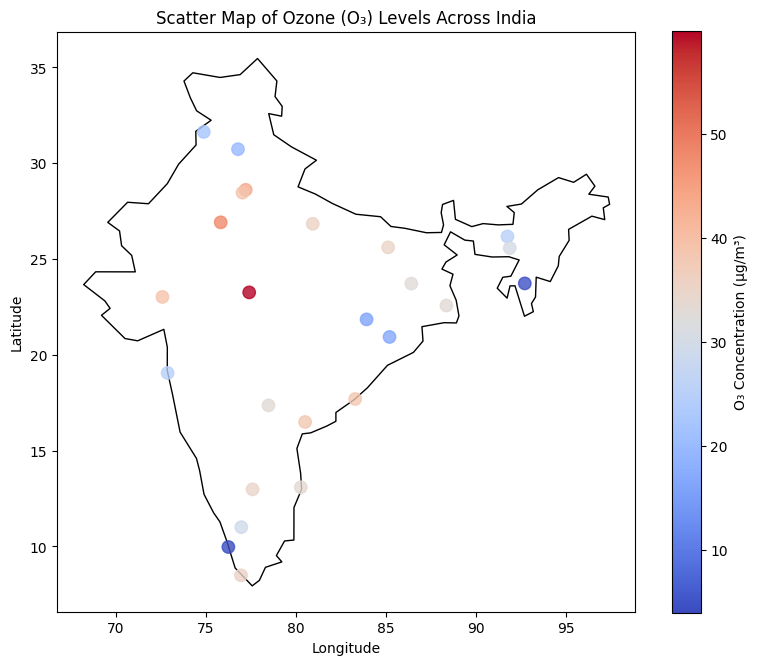

In [49]:
def map_vis(df):

    # Load Natural Earth countries (1:110m resolution)
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)

    # Filter for India
    india = world[world["ADMIN"] == "India"]


    # grouping by city as hard to see individual points otherwise

    # groups by city and takes mean of O3 values
    df_mean = df.groupby(['City']).mean('O3').reset_index()
    # Remove rows with NaN values in or 'O3' columns
    df_clean = df_mean.dropna(subset=["O3"])

    gdf = gpd.GeoDataFrame(
        df_clean,  # remove NaNs
        geometry=gpd.points_from_xy(df_clean["lon"], df_clean["lat"]),
        crs="EPSG:4326"
    )

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8, 10))
    india.plot(ax=ax, color="white", edgecolor="black")  # India boundary

    # Scatter plot of O3 levels
    gdf.plot(
        ax=ax,
        column="O3",        # pollutant column
        cmap="coolwarm",        # color scheme
        markersize=80,      # adjust dot size
        alpha=0.8,
        legend=True,
        legend_kwds={
        "label": "O₃ Concentration (µg/m³)",   # ← your legend label
        "shrink": 0.6                         # optional: smaller colorbar
    }
    )

    plt.title("Scatter Map of Ozone (O₃) Levels Across India")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

map_vis(df)

Visualising time series.

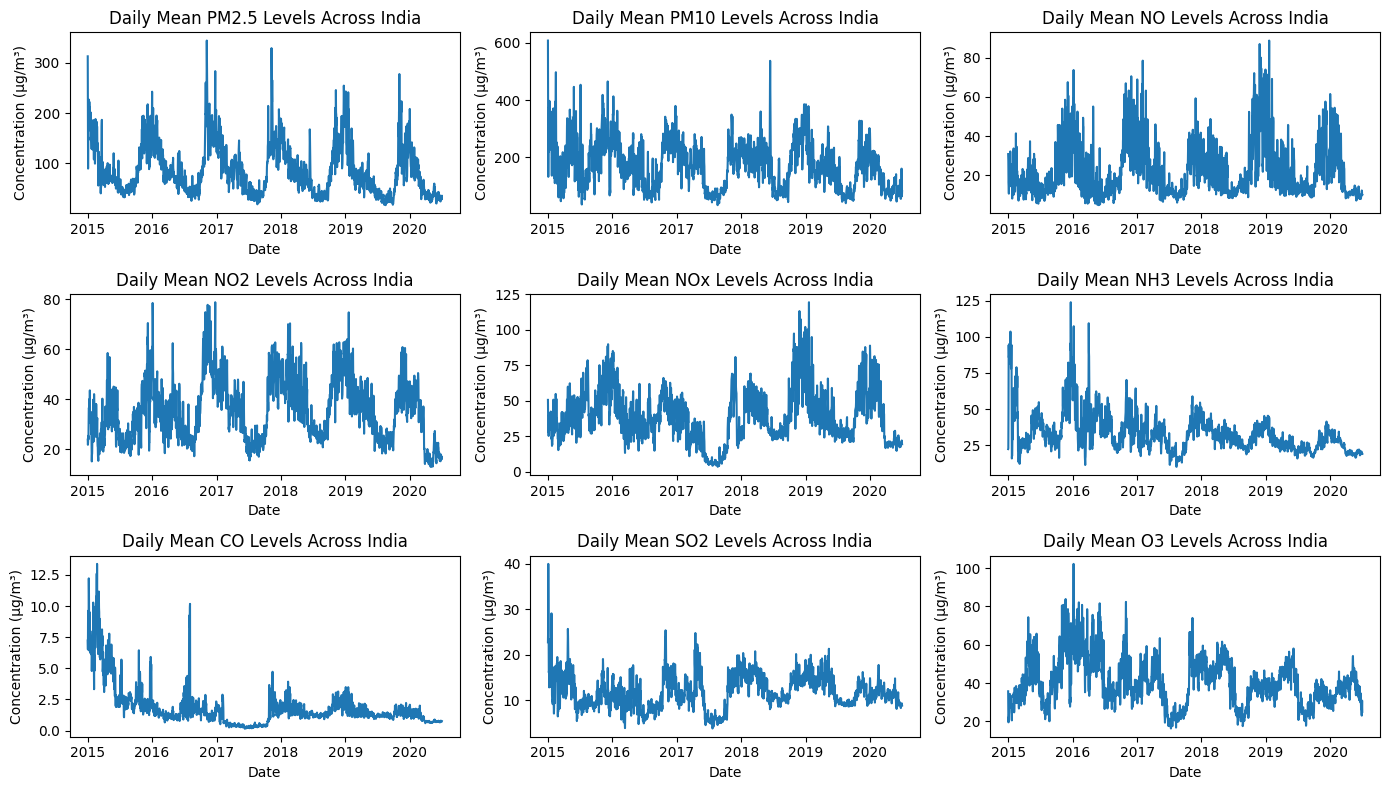

In [50]:
def ozone_time_series(df):
    
    # group by day (drop the time component)
    df_mean = (
        df.groupby(df['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x='date', y='O3')
    plt.title('Daily Mean Ozone (O₃) Levels Across India')
    plt.xlabel('Date')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.tight_layout()
    plt.show()


def all_pollutatants_time_series(df):

    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    monthly_mean = (
    df.groupby(pd.Grouper(key='datetime', freq='D'))[pollutants]
      .mean()
      .reset_index()
    )

    # plot on different graphs for clarity

    plt.figure(figsize=(14, 8))
    for i, pollutant in enumerate(pollutants, 1):
        plt.subplot(3, 3, i)
        sns.lineplot(data=monthly_mean, x='datetime', y=pollutant)
        plt.title(f'Daily Mean {pollutant} Levels Across India')
        plt.xlabel('Date')
        plt.ylabel('Concentration (µg/m³)')
        plt.tight_layout()
    plt.show()
    

#ozone_time_series(df)
all_pollutatants_time_series(df)

Random station ozone time series

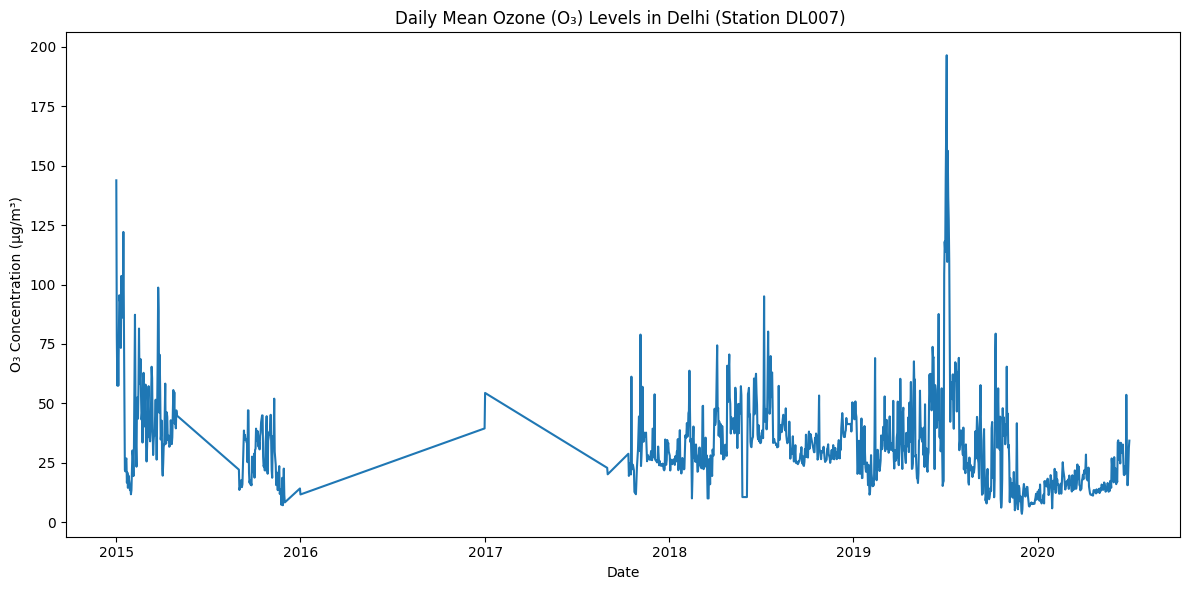

In [51]:

def random_station_ozone_time_series(df):

    # select a random city
    random_station = df['StationId'].sample(n=1).values[0]

    df_station = df[df['StationId'] == random_station]

    # group by day (drop the time component)
    df_mean = (
        df_station.groupby(df_station['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x='date', y='O3')
    plt.title(f'Daily Mean Ozone (O₃) Levels in {df_station["City"].values[0]} (Station {random_station}) ')
    plt.xlabel('Date')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.tight_layout()
    plt.show()

# can return a city with no ozone data so may need to rerun to find one that does
random_station_ozone_time_series(df)

Seasonal Trends

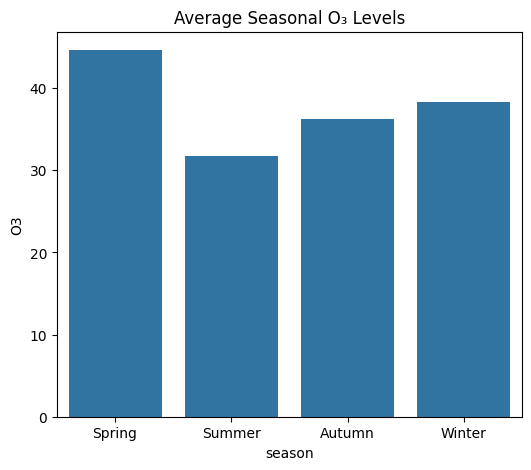

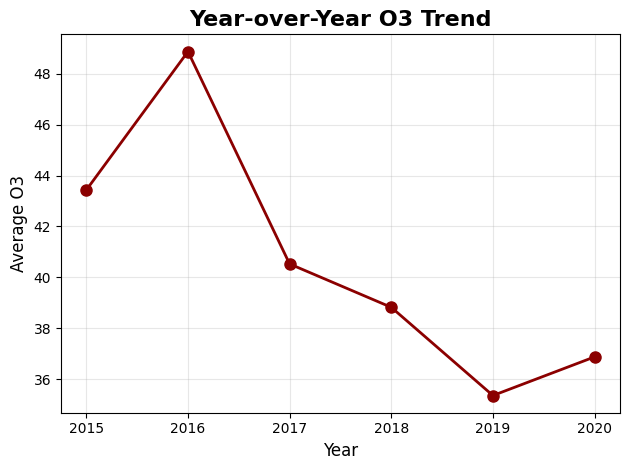

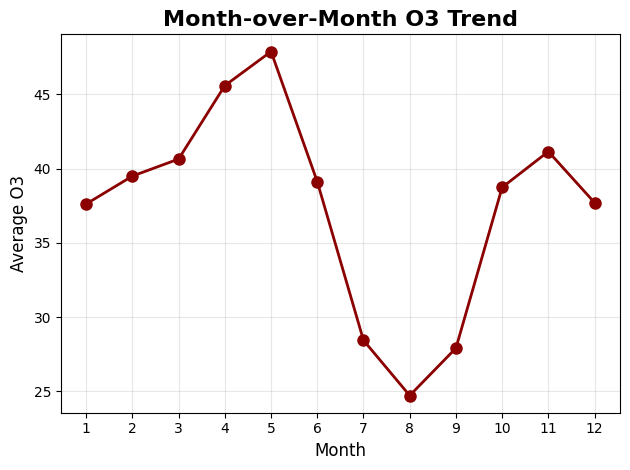

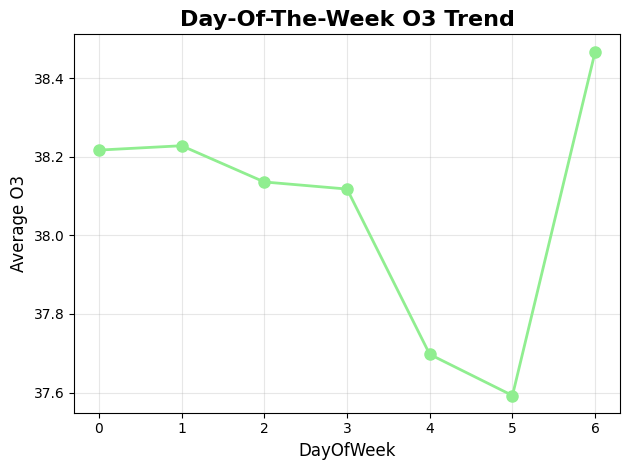

In [52]:
def yearly_fig(df):
    # Extract year from datetime
    # copy to not impact original df
    df_copy = df.copy()
    df_copy['Year'] = df_copy['datetime'].dt.year
    # # Year-over-Year O3 Trend
    yearly_O3 = df_copy.groupby('Year')['O3'].mean().reset_index()

    #print("\nYearly O3 Summary:")
    #print(yearly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(yearly_O3['Year'], yearly_O3['O3'], marker='o', linewidth=2, 
             markersize=8, color='darkred')
    plt.title('Year-over-Year O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(yearly_O3['Year'])
    plt.tight_layout()
    plt.show()

def monthly_fig(df):
    # Month-over-Month O3 Trend
    monthly_O3 = df.groupby('month')['O3'].mean().reset_index()

    #print("\nMonthly O3 Summary:")
    #print(monthly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(monthly_O3['month'], monthly_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='darkred')
    plt.title('Month-over-Month O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(monthly_O3['month'])
    plt.tight_layout()
    plt.show()

def day_of_week_fig(df):
    # Day of the week O3 Trend
    day_of_week_O3 = df.groupby('dayofweek')['O3'].mean().reset_index()

    #print("\nDaily O3 Summary:")
    #print(day_of_week_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(day_of_week_O3['dayofweek'], day_of_week_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='lightgreen')
    plt.title('Day-Of-The-Week O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('DayOfWeek', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(day_of_week_O3['dayofweek'])
    plt.tight_layout()
    plt.show()

def seasonal_trends(df):

    df_copy = df.copy()
    df_copy['weekday_name'] = df_copy['datetime'].dt.day_name()

    # Visualization
    plt.figure(figsize=(6,5))
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    df_copy['season'] = df_copy['month'].apply(get_season)

    seasonal_summary = df_copy.groupby('season')['O3'].mean().reset_index()
    sns.barplot(x='season', y='O3', data=seasonal_summary, order=['Spring', 'Summer', 'Autumn', 'Winter'])
    plt.title('Average Seasonal O₃ Levels')
    plt.show()

seasonal_trends(df)
yearly_fig(df)
monthly_fig(df)
day_of_week_fig(df)


Histograms

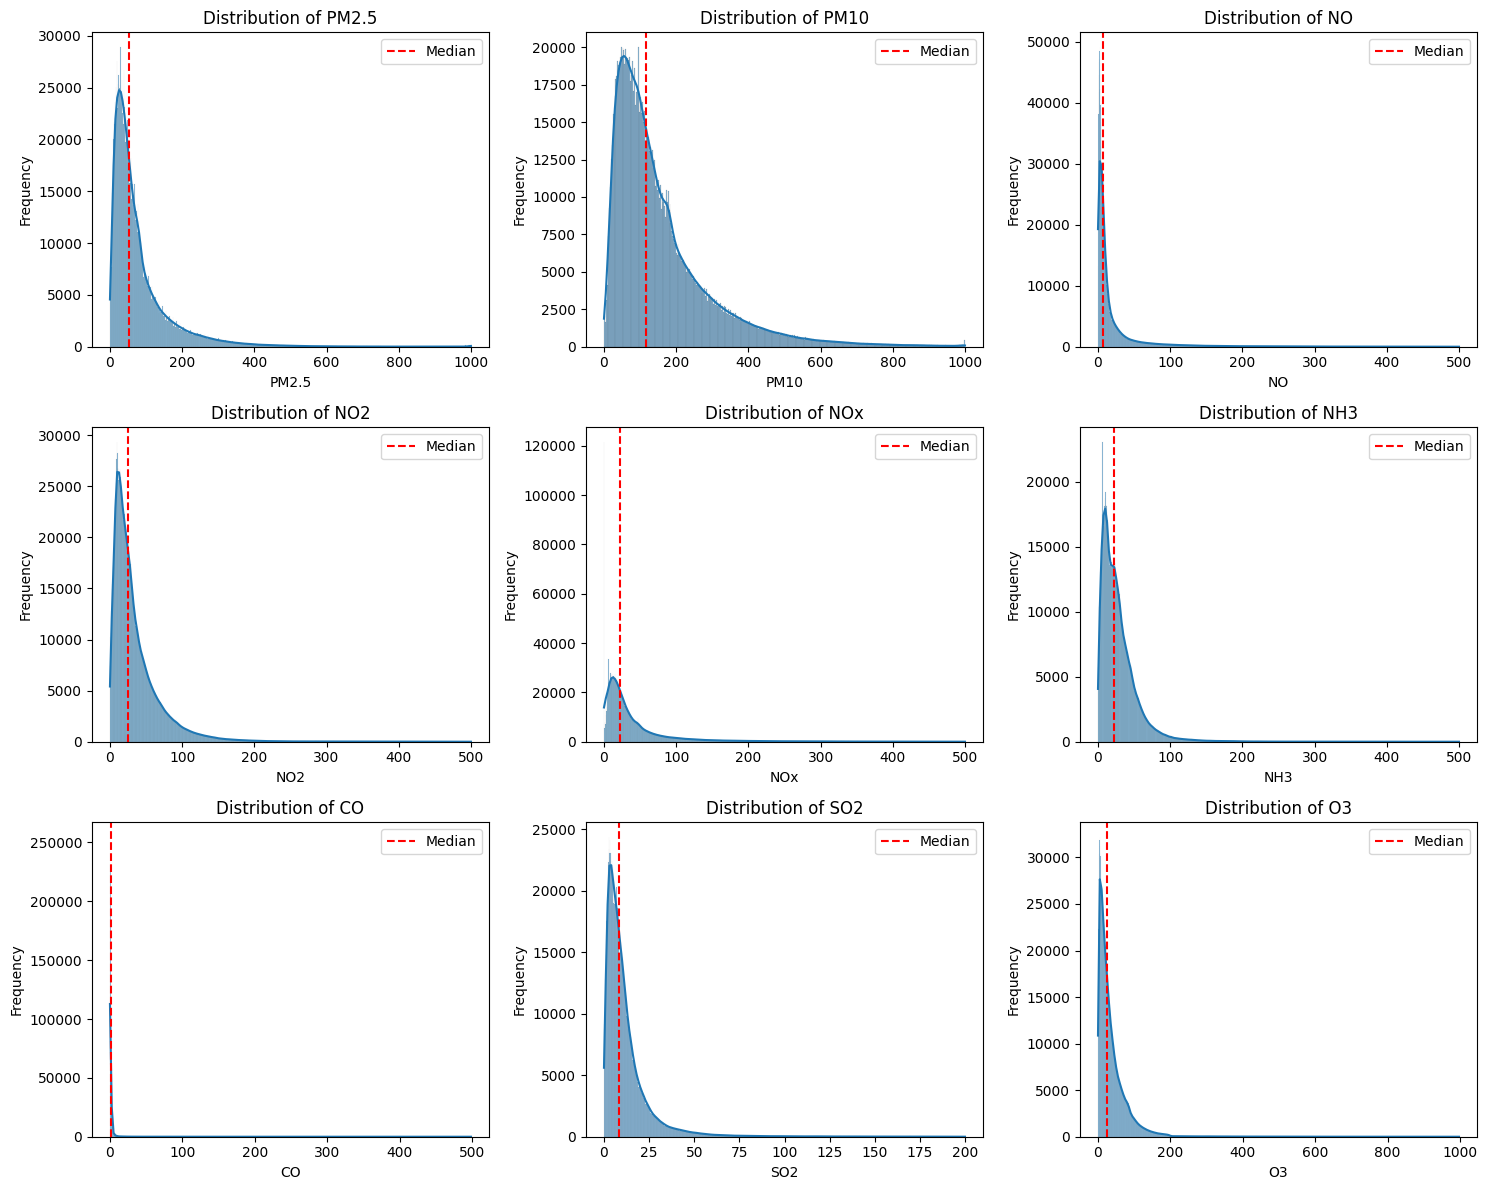

In [53]:
def histograms(df):
    numeric_features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # Create subplots for all histograms
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()  # Make indexing easier

    for i, col in enumerate(numeric_features):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].axvline(df[col].median(), color='r', linestyle='--', label='Median'),
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()


    plt.tight_layout()
    plt.show()

histograms(df)

Correlation matrix


Correlation with O3:
AQI          0.132111
hour         0.103756
SO2          0.098339
NH3          0.084150
lat          0.083183
NO2          0.060923
PM2.5        0.057122
PM10         0.002009
dayofweek   -0.001492
day         -0.007836
Name: O3, dtype: float64


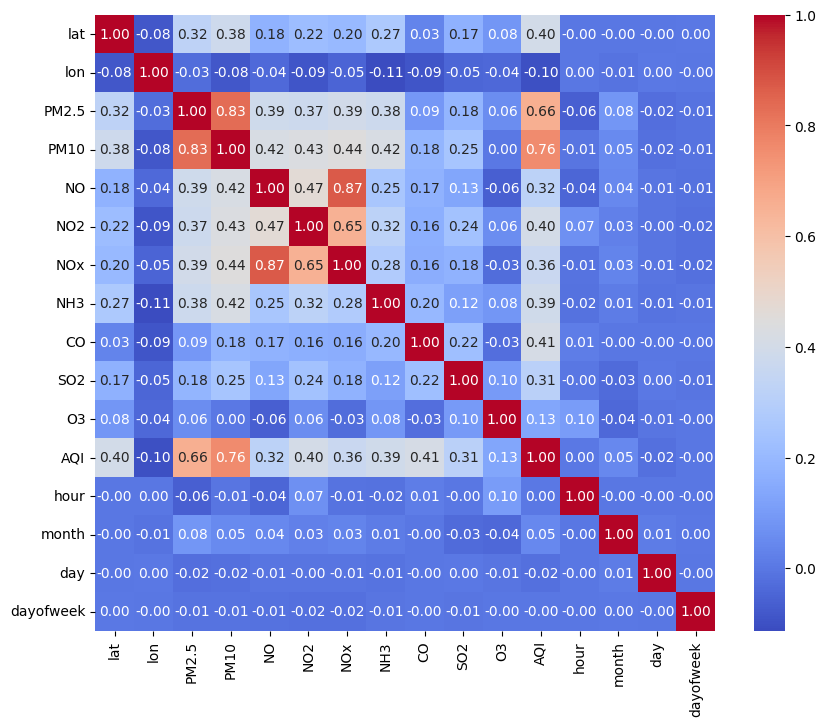

In [54]:
def correlation_matrix(df):

    # Correlation matrix for pollutants.
    df_corr = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State'], axis=1)
    corr_matrix = df_corr.corr()

    # Show strong correlations with 03
    if 'O3' in corr_matrix.columns:
        O3_corr = corr_matrix['O3'].sort_values(ascending=False)
        print("\nCorrelation with O3:")
        print(O3_corr[1:11])

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

correlation_matrix(df)

Covariance Matrix

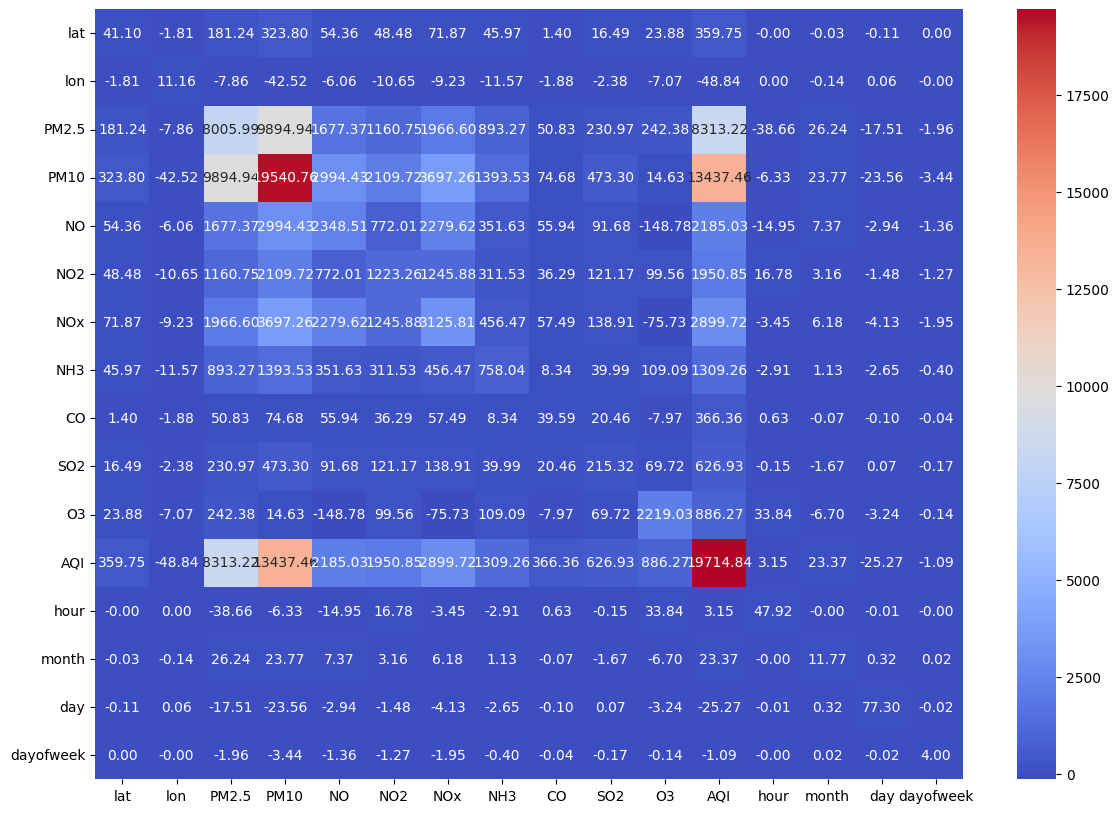

In [55]:
def cov_matrix(df):

    # Correlation matrix for pollutants.
    df_cov = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State'], axis=1)
    cov_matrix = df_cov.cov()

    plt.figure(figsize=(14, 10))
    sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm')

cov_matrix(df)

Distribution of AQI

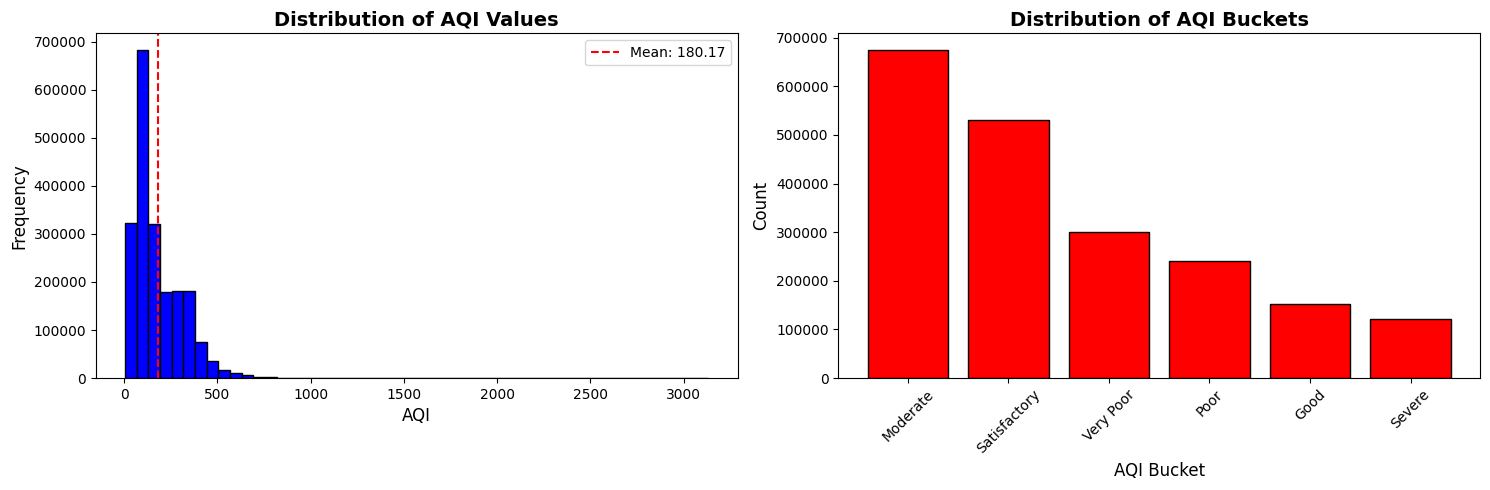

In [56]:
def aqi_plots(df):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 03 distribution
    axes[0].hist(df['AQI'].dropna(), bins=50, color='blue', edgecolor='black')
    axes[0].set_title('Distribution of AQI Values', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('AQI', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].axvline(df['AQI'].mean(), color='red', linestyle='--', label=f'Mean: {df["AQI"].mean():.2f}')
    axes[0].legend()

    # # AQI Bucket distribution
    aqi_bucket_counts = df['AQI_Bucket'].value_counts()
    axes[1].bar(aqi_bucket_counts.index, aqi_bucket_counts.values, color='red', edgecolor='black')
    axes[1].set_title('Distribution of AQI Buckets', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('AQI Bucket', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

aqi_plots(df)

Top 50 Worst days for O3 pollution all in same place.

In [57]:
def top_O3_days(df):

    df_copy = df.copy()
    df_copy['Year'] = df_copy['datetime'].dt.year
    # Get top 50 days with Highest O3
    top_O3_days = df_copy.nlargest(50, 'O3')[['datetime', 'StationName','O3']]

    print("=" * 50)
    print("Top 50 days with Highest O3")
    print("=" * 50)
    print(top_O3_days.to_string(index=False))

top_O3_days(df)

Top 50 days with Highest O3
           datetime                StationName     O3
2019-11-03 14:00:00 Punjabi Bagh, Delhi - DPCC 997.00
2018-06-13 05:00:00 Punjabi Bagh, Delhi - DPCC 996.00
2019-11-03 07:00:00 Punjabi Bagh, Delhi - DPCC 996.00
2019-01-20 00:00:00 Punjabi Bagh, Delhi - DPCC 992.00
2017-11-08 07:00:00 Punjabi Bagh, Delhi - DPCC 989.00
2016-01-04 22:00:00 Punjabi Bagh, Delhi - DPCC 988.17
2015-11-20 12:00:00 Punjabi Bagh, Delhi - DPCC 984.33
2016-01-07 09:00:00 Punjabi Bagh, Delhi - DPCC 982.00
2019-11-03 08:00:00 Punjabi Bagh, Delhi - DPCC 982.00
2017-11-08 09:00:00 Punjabi Bagh, Delhi - DPCC 980.00
2017-11-09 09:00:00 Punjabi Bagh, Delhi - DPCC 977.00
2020-01-01 23:00:00 Punjabi Bagh, Delhi - DPCC 975.00
2016-11-02 09:00:00 Punjabi Bagh, Delhi - DPCC 974.50
2017-11-12 09:00:00 Punjabi Bagh, Delhi - DPCC 974.00
2018-06-12 15:00:00 Punjabi Bagh, Delhi - DPCC 974.00
2017-11-10 10:00:00 Punjabi Bagh, Delhi - DPCC 973.00
2017-12-11 03:00:00 Punjabi Bagh, Delhi - DPCC 973.00


Average Pollutant per stations.

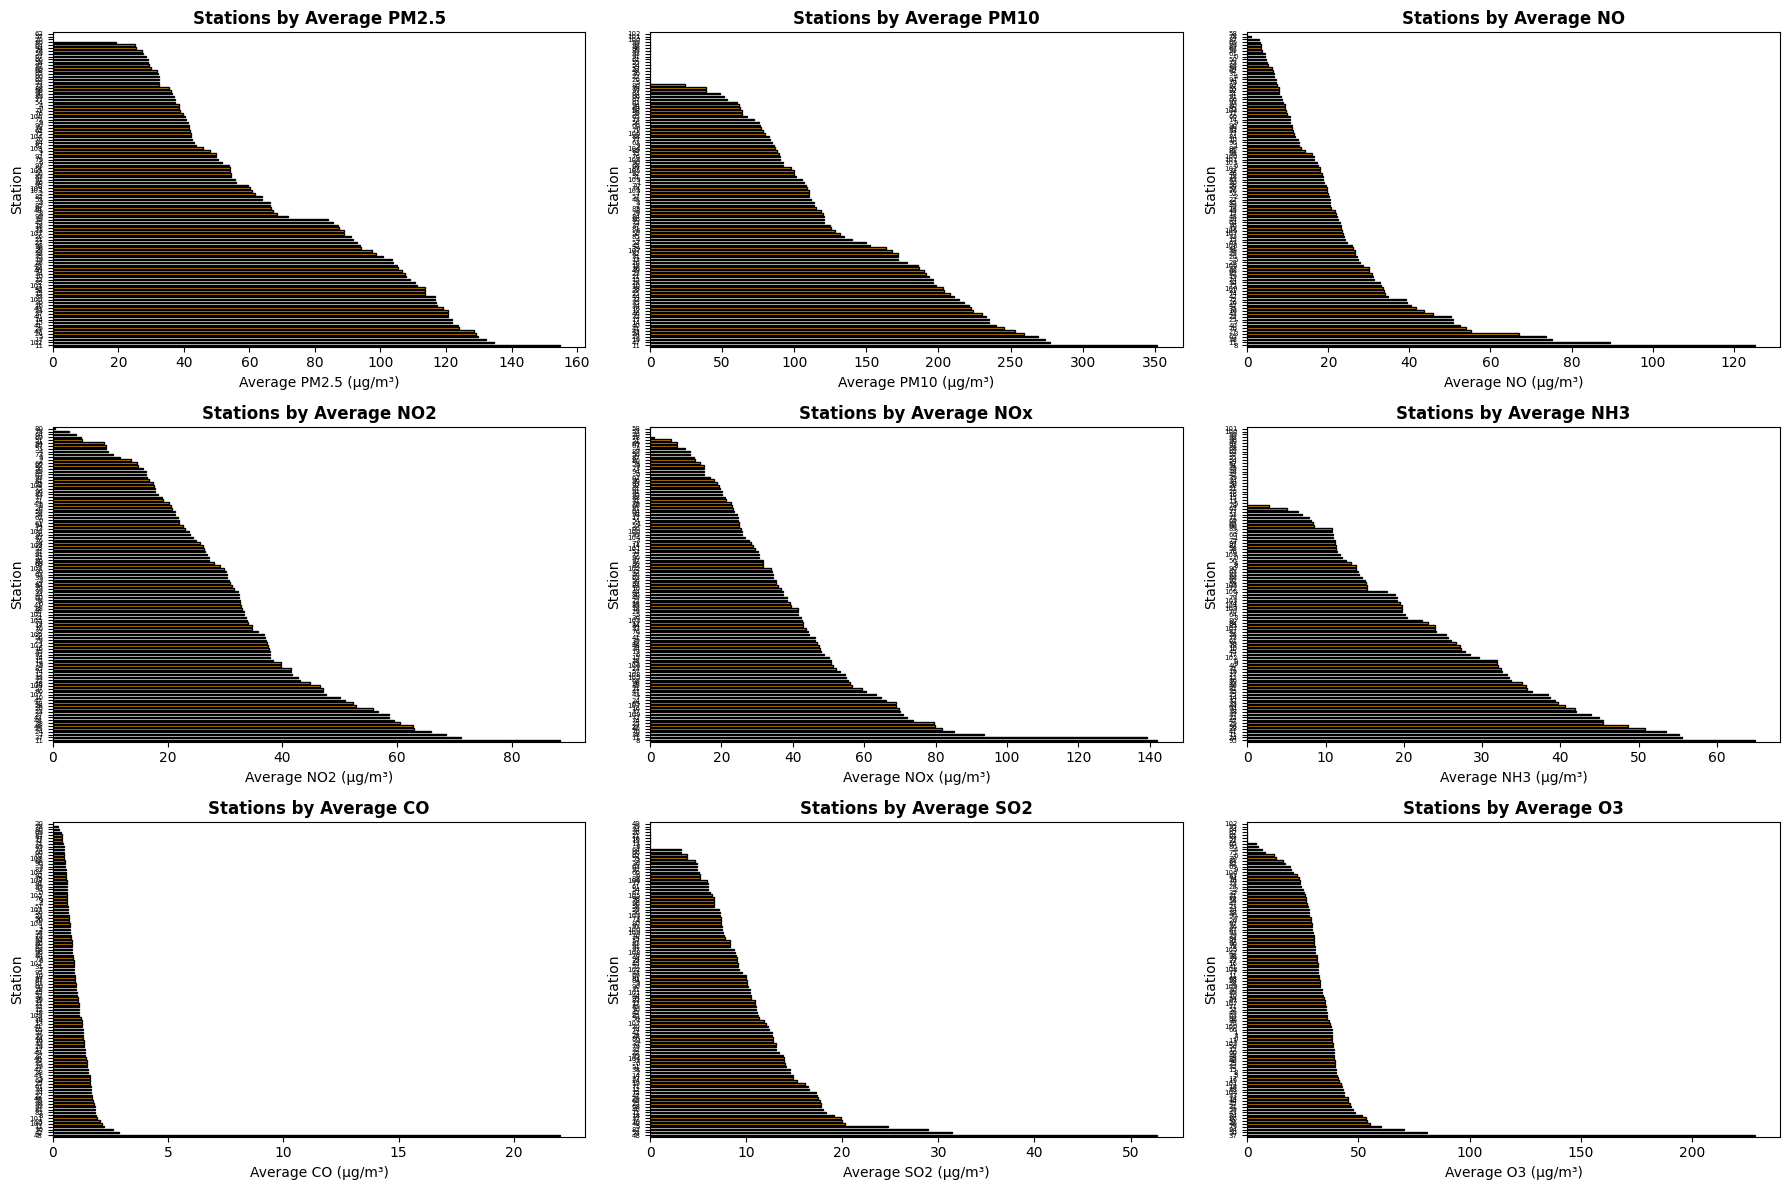

In [58]:
def avg_pollutant_by_station(df):

    # pollutant list
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    stations_mean = (
        df.groupby('StationId')[pollutants]
          .mean()
          .reset_index()
    )

    # Stations by average pollutant levels

    # Create subplots: 3 rows × 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # make axes 1D for easy looping

    # Plot each pollutant
    for i, pollutant in enumerate(pollutants):
        # Sort stations for that pollutant
        sorted_data = stations_mean[pollutant].sort_values(ascending=False)

        sorted_data.plot(
            kind='barh',
            ax=axes[i],
            color='orange',
            edgecolor='black'
        )
        axes[i].set_title(f'Stations by Average {pollutant}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(f'Average {pollutant} (µg/m³)', fontsize=10)
        axes[i].set_ylabel('Station', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=5)


    plt.tight_layout()
    plt.show()

avg_pollutant_by_station(df)

Nan value analysis.

Missing Percentage by Pollutant (%): NH3      47.762779
PM10     43.229669
SO2      28.687261
O3       28.039773
PM2.5    25.016154
AQI      22.022855
NO       21.386375
NO2      20.430902
CO       19.284897
NOx      18.956828
dtype: float64


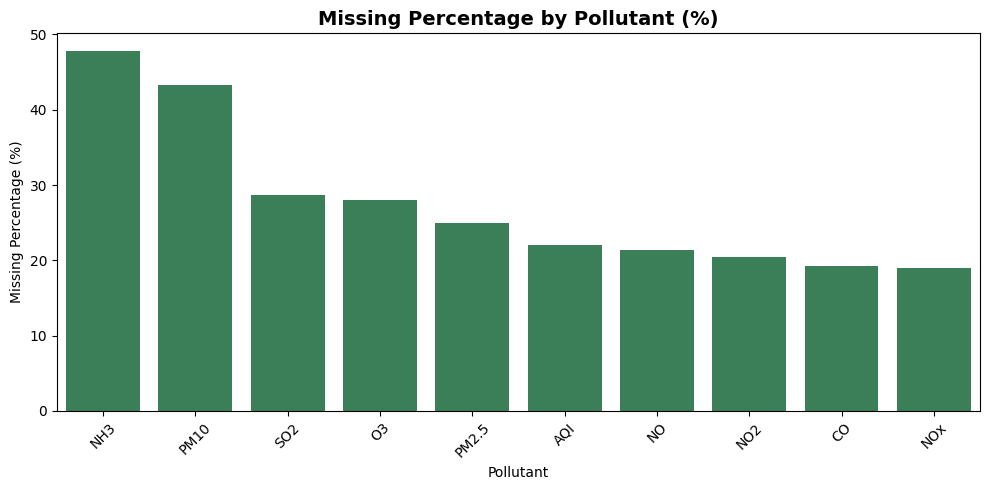

Top 10 Cities with Highest Missing Rates (%):
City
Jorapokhar      48.284746
Ahmedabad       46.816484
Chennai         37.758513
Bengaluru       36.306005
Gurugram        36.250221
Lucknow         34.655496
Patna           34.620731
Talcher         30.305492
Mumbai          29.625427
Brajrajnagar    29.408492
dtype: float64


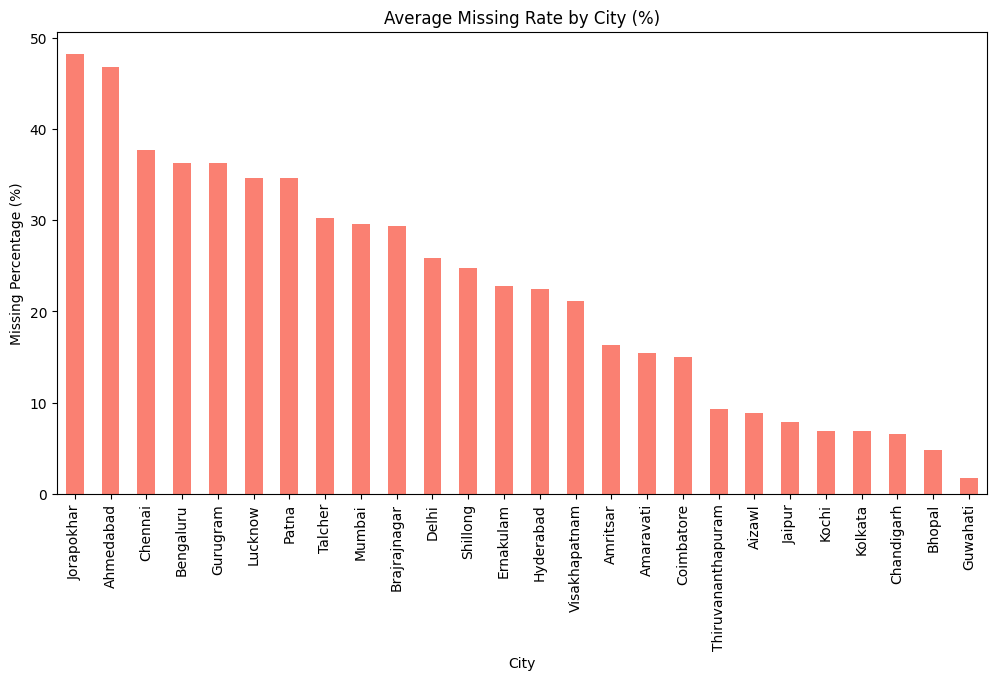

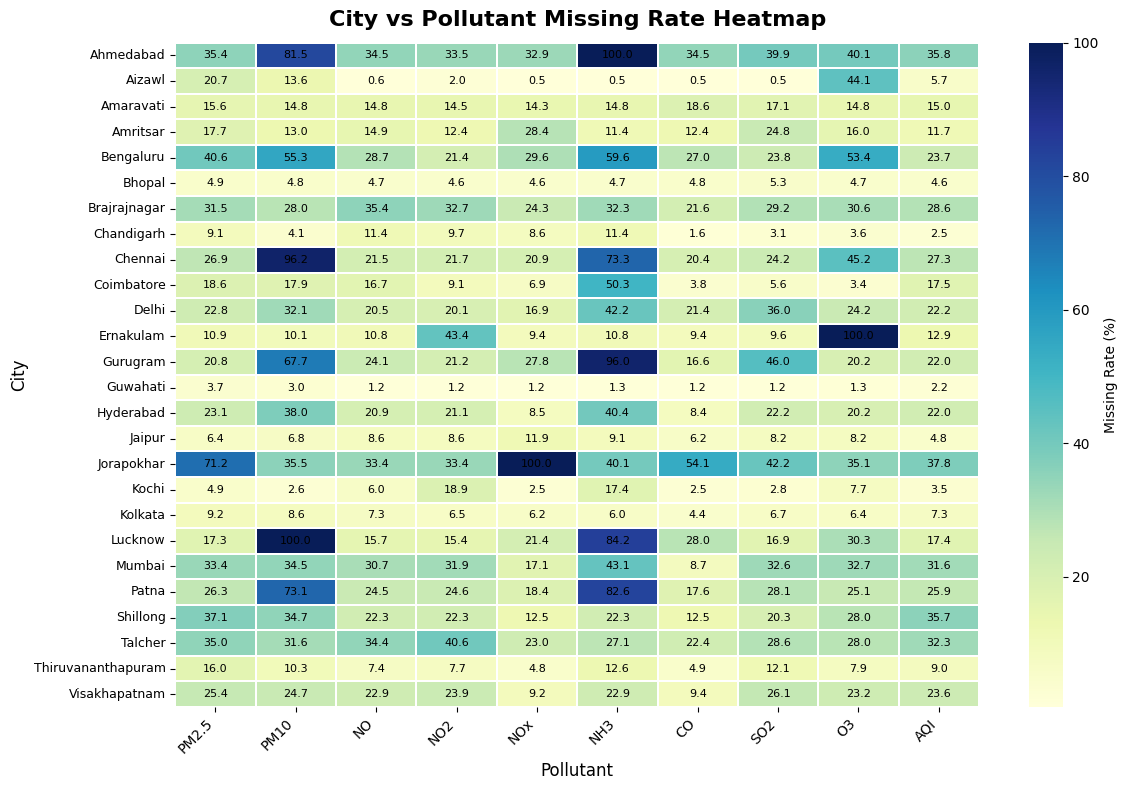

Top 10 Monitoring Stations with Highest Missing Rates:
                                              PM2.5        PM10         NO  \
StationName                                                                  
East Arjun Nagar, Delhi - CPCB           100.000000  100.000000  62.444946   
Bandra, Mumbai - MPCB                     67.193725   69.407786  67.075448   
City Railway Station, Bengaluru - KSPCB  100.000000   34.349718  33.555463   
CRRI Mathura Road, Delhi - IMD            42.496680   42.229001  43.312168   
DTU, Delhi - CPCB                         53.981989   61.012201  49.923224   
Sanegurava Halli, Bengaluru - KSPCB      100.000000   39.473684  37.860860   
IHBAS, Dilshad Garden, Delhi - CPCB       40.033616  100.000000  39.614459   
Shadipur, Delhi - CPCB                    49.109811  100.000000  23.887782   
Tata Stadium, Jorapokhar - JSPCB          71.190009   35.504014  33.423729   
ITO, Delhi - CPCB                         55.269282   46.018949  43.405086   

        

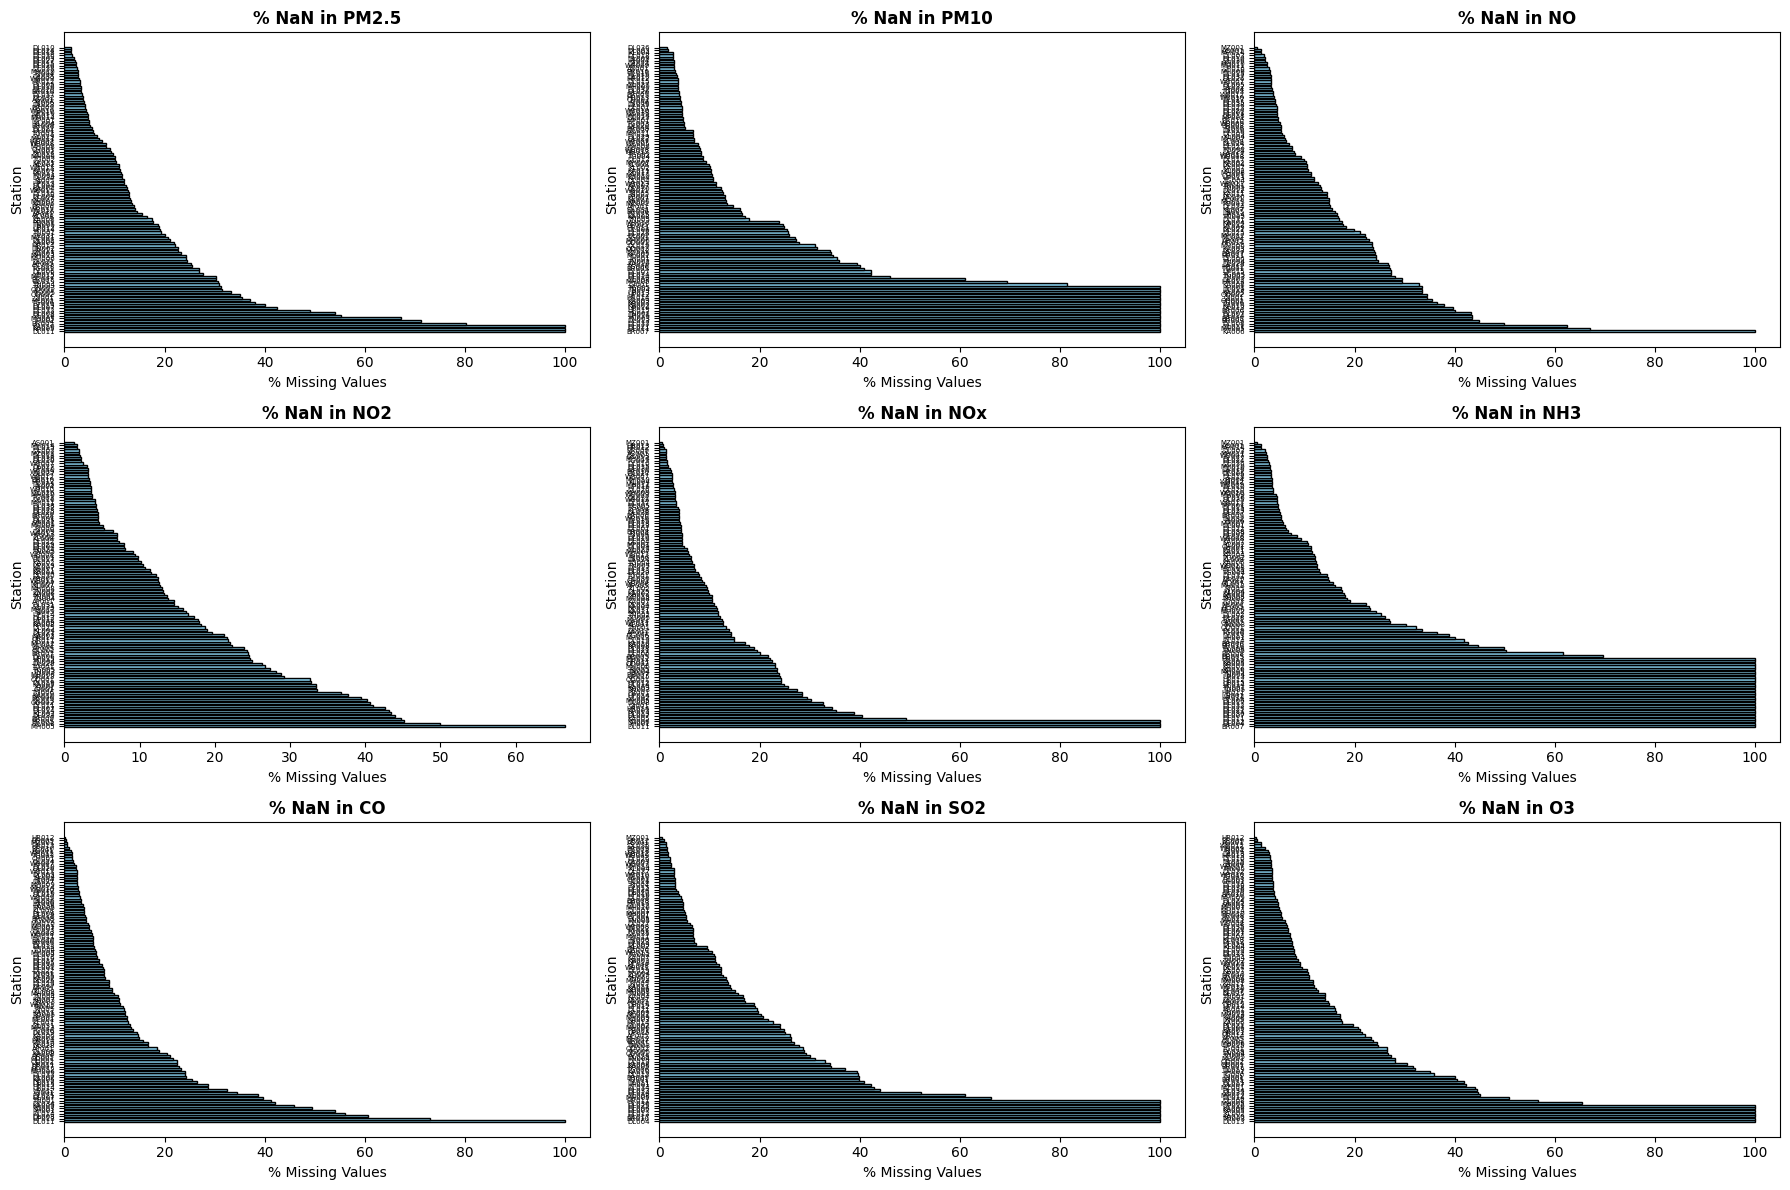

In [59]:
def nan_by_pollutant(df):

    India = df.copy()

    # Keep only pollutant-related columns
    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']


    miss_pct = {}
    for c in polls:
        total_valid = India[c].notna().sum() + India[c].isna().sum()  
        miss_pct[c] = (India[c].isna().sum() / total_valid) * 100

    miss_pct = pd.Series(miss_pct).sort_values(ascending=False)
    print("Missing Percentage by Pollutant (%):", miss_pct)

    plt.figure(figsize=(10,5))
    sns.barplot(x=miss_pct.index, y=miss_pct.values, color='seagreen')
    plt.title("Missing Percentage by Pollutant (%)", fontsize=14, fontweight='bold')
    plt.ylabel("Missing Percentage (%)")
    plt.xlabel("Pollutant")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def nan_by_city(df):

    India = df.copy()
    #--------------------------------------------------------------------------------------------------------------------------------
    # Calculate missing rate by city
    # Keep only pollutant-related columns
    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']
    
    city_miss = India.groupby('City')[polls].apply(lambda x: x.isnull().mean() * 100)
    city_miss_mean = city_miss.mean(axis=1).sort_values(ascending=False)

    print("Top 10 Cities with Highest Missing Rates (%):")
    print(city_miss_mean.head(10))

    plt.figure(figsize=(12,6))
    city_miss_mean.plot(kind='bar', color='salmon')
    plt.title("Average Missing Rate by City (%)")
    plt.ylabel("Missing Percentage (%)")
    plt.xlabel("City")
    plt.show()

    plt.figure(figsize=(12,8))
    sns.heatmap(
        city_miss,
        cmap='YlGnBu',       
        linewidths=0.3,       
        linecolor='white',
        cbar_kws={'label': 'Missing Rate (%)'},
        annot=True,             
        fmt=".1f",            
        annot_kws={'size':8, 'color':'black'} 
    )

    plt.title("City vs Pollutant Missing Rate Heatmap", fontsize=16, fontweight='bold', pad=12)
    plt.xlabel("Pollutant", fontsize=12)
    plt.ylabel("City", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

def nan_by_station(df):

    India = df.copy()
    #  Calculate missing rate by monitoring station

    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']

    station_miss = India.groupby('StationName')[polls].apply(lambda x: x.isnull().mean() * 100)
    station_miss['Average'] = station_miss.mean(axis=1)
    station_miss = station_miss.sort_values('Average', ascending=False)

    print("Top 10 Monitoring Stations with Highest Missing Rates:")
    print(station_miss.head(10))

def nan_percent_by_station(df):

    # pollutant list
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # Calculate % of NaN values for each pollutant per station
    stations_nan_pct = (
        df.groupby('StationId')[pollutants]
          .apply(lambda x: x.isna().mean() * 100)
          .reset_index()
    )

    # Create subplots: 3 rows × 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # make axes 1D for easy looping

    # Plot each pollutant
    for i, pollutant in enumerate(pollutants):
        # Sort stations by % NaN for that pollutant
        sorted_data = stations_nan_pct.sort_values(by=pollutant, ascending=False)

        axes[i].barh(sorted_data['StationId'], sorted_data[pollutant],
                     color='skyblue', edgecolor='black')

        axes[i].set_title(f'% NaN in {pollutant}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('% Missing Values', fontsize=10)
        axes[i].set_ylabel('Station', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=5)

    plt.tight_layout()
    plt.show()

nan_by_pollutant(df)
nan_by_city(df)
nan_by_station(df)
nan_percent_by_station(df)

Outliers.

imputing for nan values

## Modelling

data set prep and splitting

In [3]:
# Remove rows where target variable (O3) is missing
df_clean = df.dropna(subset=['O3'])

# Prepare features and target - EXCLUDE O3 from features since it's our target
feature_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'hour', 'month', 'dayofweek']
X = df_clean[feature_columns]  # Can contain NaN values
y = df_clean['O3']  # Should not contain NaN

# Split into train-test FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


random forest

Train MAE: 5.52
Train MSE: 96.42
Train RMSE: 9.82
Train R²: 0.96
Test MAE: 14.66
Test MSE: 680.16
Test RMSE: 26.08
Test R²: 0.70


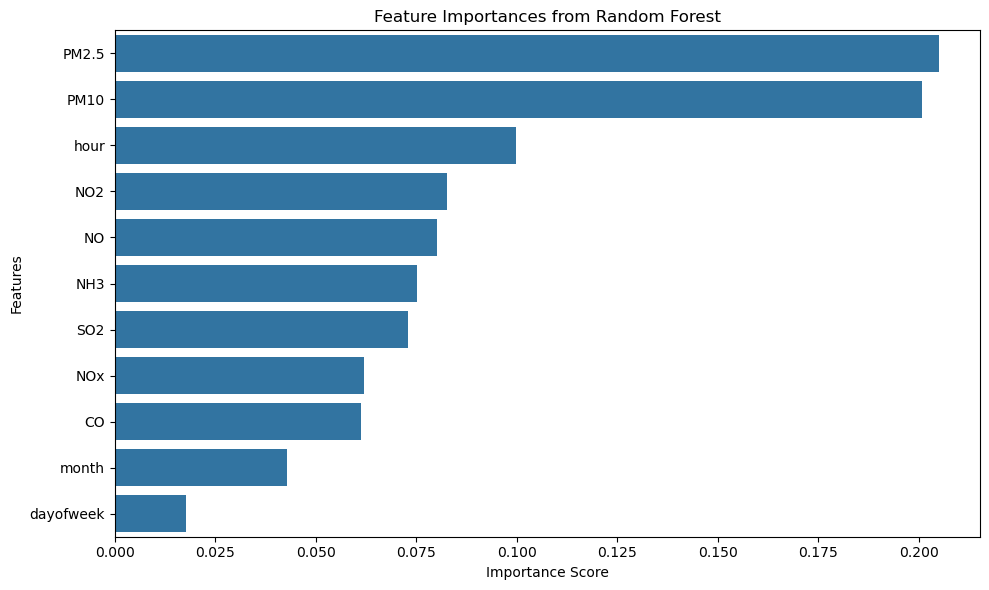

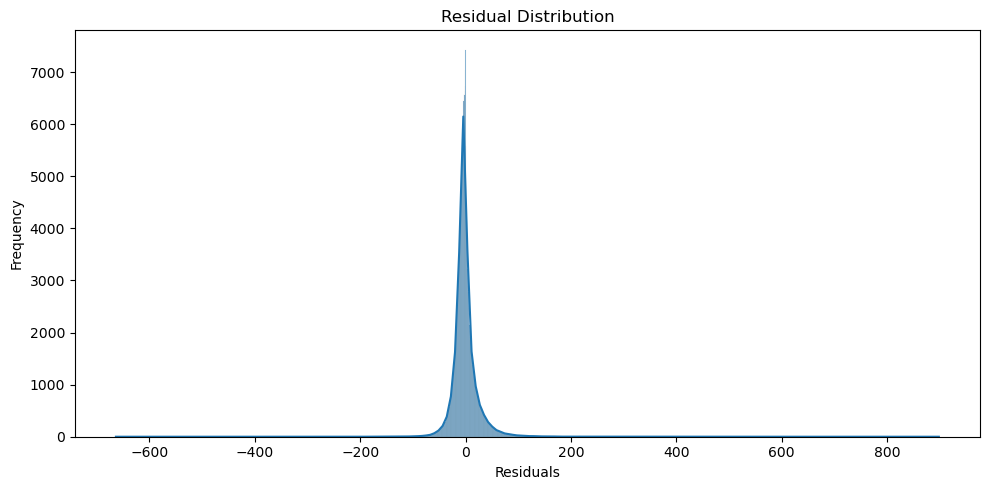

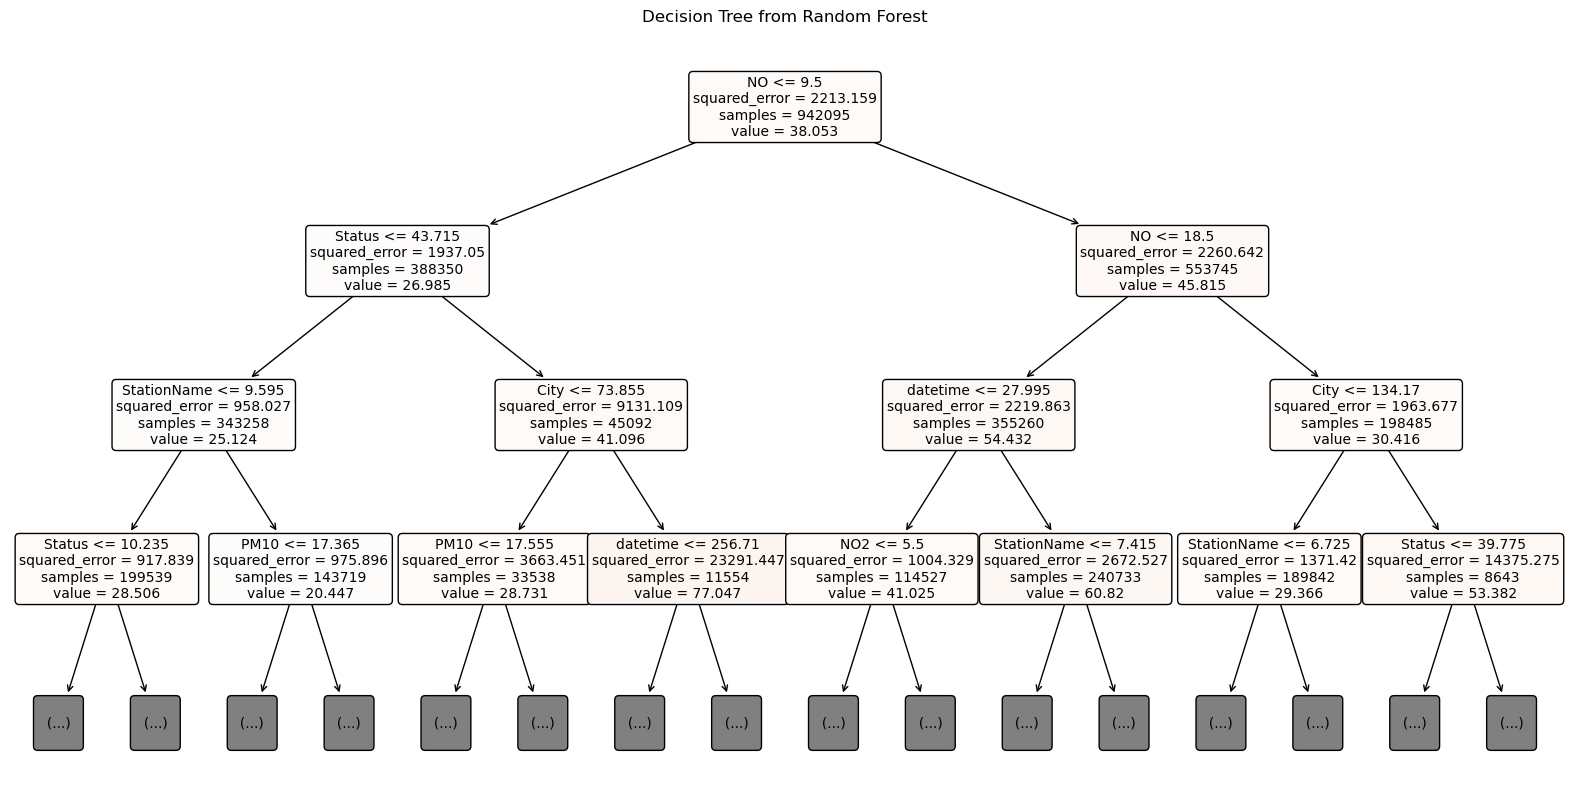

In [5]:
def random_forest_grid_search(X_train, X_test, y_train, y_test):

    param_grid = {
    'max_features': [0.6, 0.8, 1, 'sqrt', 'log2'],
    'max_samples': [0.6, 0.8, 1],
    'max_depth': [10, 20, None]

    }

    grid = HalvingGridSearchCV(
        estimator=RandomForestRegressor(n_estimators=100, random_state=1),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose =2
    )

    grid.fit(X_train, y_train)

    print("Best Parameters:", grid.best_params_)
    print("Best Score:", -grid.best_score_)

    return grid.best_estimator_

def random_forest(X_train, X_test, y_train, y_test, best_params = None):

    # Then create and fit model ONLY on training data
    if best_params:
        regr = RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            max_features=best_params['max_features'],
            max_samples=best_params['max_samples'],
            max_depth=best_params['max_depth']
        )
    else:
        regr = RandomForestRegressor(
            n_estimators=100,
            random_state=42
        )

    regr.fit(X_train, y_train)

    # Predictions
    y_train_pred = regr.predict(X_train)
    y_test_pred = regr.predict(X_test)

    # Evaluation
    def evaluate(y_true, y_pred, dataset_type="Test"):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        print(f"{dataset_type} MAE: {mae:.2f}")
        print(f"{dataset_type} MSE: {mse:.2f}")
        print(f"{dataset_type} RMSE: {rmse:.2f}")
        print(f"{dataset_type} R²: {r2:.2f}")

    evaluate(y_train, y_train_pred, "Train")
    evaluate(y_test, y_test_pred, "Test")

    def plotting():

        # Feature Importance
        importances = regr.feature_importances_
        feature_names = X_train.columns
        feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        # plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances, y=feature_importances.index)
        plt.title('Feature Importances from Random Forest')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

        # Residual Analysis
        residuals = y_test - y_test_pred
        plt.figure(figsize=(10, 5))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # plotting tree
        tree_to_plot = regr.estimators_[0]

        plt.figure(figsize=(20, 10))
        plot_tree(tree_to_plot, max_depth = 3, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
        plt.title("Decision Tree from Random Forest")
        plt.show()

    plotting()

    return regr

random_forest_model = random_forest(X_train, X_test, y_train, y_test)



xgboost

R²: 0.567
RMSE: 31.360
MAE: 20.015
Cross-Validation Mean R²: 0.162 ± 0.068

Permutation Feature Importances:
PM10         0.663731
PM2.5        0.462548
hour         0.178862
NH3          0.161387
NO2          0.128952
NO           0.108325
NOx          0.047707
month        0.045139
SO2          0.042191
CO           0.011088
dayofweek    0.000030
dtype: float64


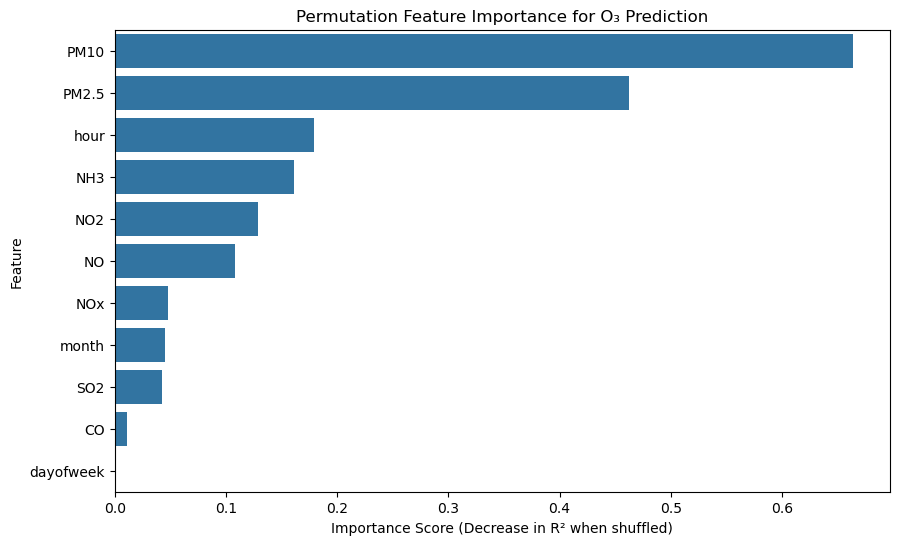

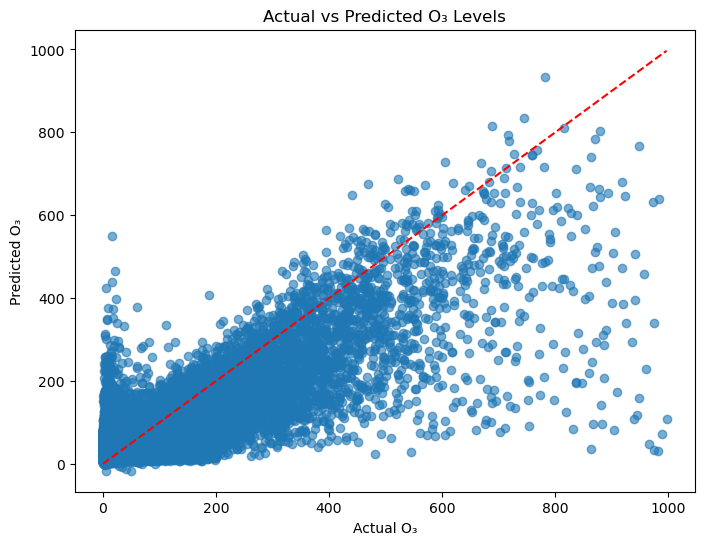

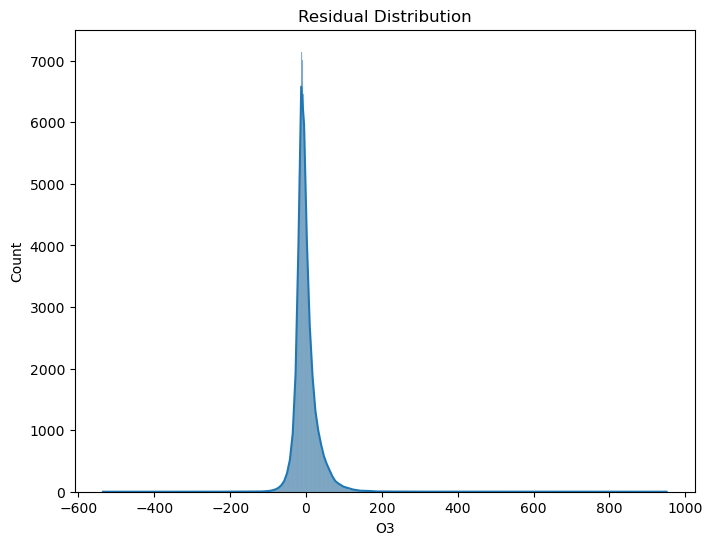

In [17]:
def xg_boost(X_train, X_test, y_train, y_test):

    # Then create and fit model ONLY on training data
    model = HistGradientBoostingRegressor(
        random_state=42,
        max_iter=100  # equivalent to n_estimators in RF
    )

    # Fit directly with NaN values
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f'R²: {r2:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')

    # Cross-validation - create fresh model for CV
    cv_model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
    cv_scores = cross_val_score(cv_model, X, y, cv=5, scoring='r2')
    print(f'Cross-Validation Mean R²: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}')

    # Use permutation importance
    from sklearn.inspection import permutation_importance

    # Calculate permutation importance on test set
    perm_importance = permutation_importance(model, X_test, y_test, random_state=42, n_repeats=10)
    importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)

    print("\nPermutation Feature Importances:")
    print(importances)

    plt.figure(figsize=(10,6))
    sns.barplot(x=importances.values, y=importances.index)
    plt.title('Permutation Feature Importance for O₃ Prediction')
    plt.xlabel('Importance Score (Decrease in R² when shuffled)')
    plt.ylabel('Feature')
    plt.show()

    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel("Actual O₃")
    plt.ylabel("Predicted O₃")
    plt.title("Actual vs Predicted O₃ Levels")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect fit line
    plt.show()

    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8,6))
    sns.histplot(residuals, kde=True)
    plt.title('Residual Distribution')
    plt.show()

    # return results or model

xg_boost(X_train, X_test, y_train, y_test)

Linear regression

In [31]:
# ============================================================
#  Subsample + Median Imputation + Linear Regression Model
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# ------------------------------------------------------------
# 1. Prepare Data
# ------------------------------------------------------------


df_sample = df.sample(frac=0.1, random_state=42)
print(f" Sample size: {len(df_sample)} rows (10% of full data)")


features = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','hour','month','dayofweek']
target = 'O3'

df_sub = df_sample[features + [target]].copy()


imputer = SimpleImputer(strategy='median')
df_filled = pd.DataFrame(imputer.fit_transform(df_sub), columns=df_sub.columns)

print(" Missing values filled with median successfully.")
print(df_filled.isna().sum())

# ------------------------------------------------------------
# 2. Train-Test Split
# ------------------------------------------------------------
X = df_filled[features]
y = df_filled[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 3. Standardization
# ------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------------------------------------
# 4. Linear Regression Model
# ------------------------------------------------------------
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Prediction
y_pred = model.predict(X_test_scaled)

# ------------------------------------------------------------
# 5. Evaluation
# ------------------------------------------------------------
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n📈 Model Performance after Median Imputation:")
print(f"R² = {r2:.3f}")
print(f"RMSE = {rmse:.3f}")


✅ Sample size: 258908 rows (10% of full data)
✅ Missing values filled with median successfully.
PM2.5        0
PM10         0
NO           0
NO2          0
NOx          0
NH3          0
CO           0
SO2          0
hour         0
month        0
dayofweek    0
O3           0
dtype: int64

📈 Model Performance after Median Imputation:
R² = 0.034
RMSE = 38.485


In [5]:
# ============================================================
#  Function: Linear Regression Pipeline for O₃ Prediction
# ============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

def run_linear_regression(df_clean, feature_columns):
    # Prepare features and target
    X = df_clean[feature_columns]
    y = df_clean['O3']

    # Remove rows with any NaN in X or y
    data = pd.concat([X, y], axis=1).dropna()
    X = data[feature_columns]
    y = data['O3']

    print(f"\nSamples after removing NaN in features/target: {len(X)}")

    # Split into train-test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train linear regression model
    lin_model = LinearRegression()
    lin_model.fit(X_train_scaled, y_train)

    # Output model equation
    coef = pd.Series(lin_model.coef_, index=feature_columns)
    intercept = lin_model.intercept_

    print("\nLinear Regression Model Formula:")
    eq = f"O₃ = {intercept:.3f}"
    for f, c in coef.items():
        sign = '+' if c >= 0 else '-'
        eq += f" {sign} {abs(c):.3f}×{f}"
    print(eq)

    # Model evaluation
    y_pred = lin_model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\nModel Performance: R² = {r2:.3f}, RMSE = {rmse:.3f}")
    print("\nPipeline Completed: Data Cleaning + Model Training + Evaluation Done.")

    return lin_model, r2, rmse


# Example usage:
model, r2, rmse = run_linear_regression(df_clean, feature_columns)



Samples after removing NaN in features/target: 972459

Linear Regression Model Formula:
O₃ = 41.452 + 16.269×PM2.5 - 15.144×PM10 - 10.622×NO + 2.971×NO2 + 4.768×NOx + 3.160×NH3 - 1.686×CO + 6.610×SO2 + 5.760×hour - 2.243×month - 0.112×dayofweek

Model Performance: R² = 0.075, RMSE = 51.491

Pipeline Completed: Data Cleaning + Model Training + Evaluation Done.


svm

In [ ]:
# Remove rows where target variable (O3) is missing
df_clean = df.dropna(subset=['O3'])

# Prepare features and target - EXCLUDE O3 from features since it's our target
feature_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'hour', 'month', 'dayofweek']
X = df_clean[feature_columns]  # Can contain NaN values
y = df_clean['O3']  # Should not contain NaN


# Split into train-test FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
# ============================================================
#  Function: SVR Grid Search — Clean NaN, Subsample, Find Best Params
# ============================================================


def svr_grid_search_with_data(X_train, y_train, sample_n=100000):
   

    # 1. Combine and drop NaN
    data = pd.concat([X_train, y_train], axis=1).dropna()
    if sample_n is not None and len(data) > sample_n:
        data = data.sample(n=sample_n, random_state=42)

    X_train_clean = data[X_train.columns]
    y_train_clean = data[y_train.name]

    print(f"Samples after NaN removal and sampling: {len(X_train_clean)}")

    # 2. Standardization
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train_clean)
    y_train_scaled = scaler_y.fit_transform(y_train_clean.values.reshape(-1, 1)).ravel()

    # 3. Parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 50, 100],
        'gamma': ['scale', 0.1, 0.01, 0.001],
        'epsilon': [0.01, 0.1, 0.2]
    }

    # 4. Grid Search (Successive Halving)
    grid = HalvingGridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train_scaled, y_train_scaled)

    # 5. Output results
    print("\nBest Parameters Found:")  
    print(grid.best_params_)
    print(f"Best Cross-Validation R²: {grid.best_score_:.3f}")

    return grid.best_params_, grid.best_estimator_

# ------------------------------------------------------------
# Function 2: Run Standard SVR Regression Pipeline
# ------------------------------------------------------------
def run_svr_regression(df_clean, feature_columns, sample_n=1000000, model=None):
    """
    Run SVR training + evaluation pipeline.
    If a tuned model is provided (from svr_grid_search), it will be used directly.
    """

    # ------------------------------------------------------------
    # 1. Prepare data
    # ------------------------------------------------------------
    df = df_clean.dropna(subset=feature_columns + ['O3'])
    if sample_n is not None and len(df) > sample_n:
        df = df.sample(n=sample_n, random_state=42)

    X = df[feature_columns]
    y = df['O3']

    print(f"\nUsing features: {feature_columns}")
    print(f"Total samples after cleaning: {len(df)}")

    # ------------------------------------------------------------
    # 2. Split train/test
    # ------------------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # ------------------------------------------------------------
    # 3. Standardization
    # ------------------------------------------------------------
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

    # ------------------------------------------------------------
    # 4. Train or load model
    # ------------------------------------------------------------
    if model is None:
        print("\nTraining default SVR model (C=10, gamma='scale', epsilon=0.1)...")
        model = SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1)
        model.fit(X_train_scaled, y_train_scaled)
    else:
        print("\nUsing pretrained/best SVR model from grid search...")
        model.fit(X_train_scaled, y_train_scaled)

    # ------------------------------------------------------------
    # 5. Predict (inverse transform)
    # ------------------------------------------------------------
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # ------------------------------------------------------------
    # 6. Evaluate
    # ------------------------------------------------------------
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\nSVR Model Performance: R² = {r2:.3f}, RMSE = {rmse:.3f}")
    
    print("\nSVR Pipeline Completed: Data Cleaning + Training + Evaluation Done.")

    return model, r2, rmse

model, r2, rmse = run_svr_regression(df_clean, feature_columns)
#best_params, best_model = svr_grid_search_with_data(X_train, y_train)




Using features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'hour', 'month', 'dayofweek']
Total samples after cleaning: 100000

Training default SVR model (C=10, gamma='scale', epsilon=0.1)...

SVR Model Performance: R² = 0.468, RMSE = 38.684

SVR Pipeline Completed: Data Cleaning + Training + Evaluation Done.


knn

In [12]:
# ============================================================
#  Function: K-Nearest Neighbors (KNN) Regression Pipeline for O₃ Prediction
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error


def knn_grid_search_with_data(X_train, y_train, sample_n=3000):
   
    print("\nStarting KNN Grid Search (auto-clean & subsample)...")

    # 1. Combine and drop NaN
    data = pd.concat([X_train, y_train], axis=1).dropna()
    if sample_n is not None and len(data) > sample_n:
        data = data.sample(n=sample_n, random_state=42)

    X_train_clean = data[X_train.columns]
    y_train_clean = data[y_train.name]

    print(f"Samples after NaN removal and sampling: {len(X_train_clean)}")

    # 2. Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)

    # 3. Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan', 'euclidean']
    }

    # 4. Grid Search (successive halving)
    grid = HalvingGridSearchCV(
        estimator=KNeighborsRegressor(),
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train_scaled, y_train_clean)

    # 5. Output results
    print("\nBest Parameters Found:")
    print(grid.best_params_)
    print(f"Best Cross-Validation R²: {grid.best_score_:.3f}")

    return grid.best_params_, grid.best_estimator_

def run_knn_regression(df_clean, feature_columns,):
    # ------------------------------------------------------------
    # 1. Prepare data
    # ------------------------------------------------------------
    
    df = df_clean.dropna(subset=feature_columns + ['O3'])                 
    
        

    X = df[feature_columns]
    y = df['O3']

    print(f"\nUsing features: {feature_columns}")
    print(f"Total samples after cleaning: {len(df)}")

    # # Step 1: Keep only necessary columns (features + O3)
    # df = df_clean[feature_columns + ['O3']].copy()

    # # Step 2: Remove rows where O3 (target) is missing
    # df = df.dropna(subset=['O3'])

    # # Step 3: Fill missing values in features using median
    # imputer = SimpleImputer(strategy='median')
    # df[feature_columns] = imputer.fit_transform(df[feature_columns])

    # print(f"Total samples after O3 cleaning: {len(df)}")
    # print("Missing values in features successfully filled with median.")

    #-----------------------------------------------------------
    # 2. Split train/test
    # ------------------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # ------------------------------------------------------------
    # 3. Standardization
    # ------------------------------------------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ------------------------------------------------------------
    # 4. Train KNN model
    # ------------------------------------------------------------
    knn_model = KNeighborsRegressor(
        n_neighbors=5,      # Number of neighbors
        weights='distance', # Weighting method
        metric='minkowski'  # Distance metric
    )
    knn_model.fit(X_train_scaled, y_train)

    # ------------------------------------------------------------
    # 5. Prediction
    # ------------------------------------------------------------
    y_pred = knn_model.predict(X_test_scaled)

    # ------------------------------------------------------------
    # 6. Evaluation
    # ------------------------------------------------------------
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\nKNN Model Performance: R² = {r2:.3f}, RMSE = {rmse:.3f}")

    return knn_model, r2, rmse

# Example usage
model, r2, rmse = run_knn_regression(df_clean, feature_columns)
#best_params, best_model = knn_grid_search_with_data(X_train, y_train, sample_n=3000)


    


Using features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'hour', 'month', 'dayofweek']
Total samples after cleaning: 972459

KNN Model Performance: R² = 0.687, RMSE = 29.963


In [14]:
# ============================================================
#  KNN Regression Pipeline with Multiple Imputation Methods
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # required
from sklearn.impute import IterativeImputer

# ============================================================
# 1️⃣  Different Missing-Value Imputation Methods
# ============================================================

def fill_missing_median(df, feature_columns):
    """Fill missing values using Median."""
    print("\n🧮 Filling missing values using Median...")
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = SimpleImputer(strategy='median')
    df_copy[feature_columns] = imputer.fit_transform(df_copy[feature_columns])
    print("✅ Median imputation completed.")
    return df_copy


def fill_missing_knn(df, feature_columns, n_neighbors=5):
    """Fill missing values using KNNImputer."""
    print(f"\n🔹 Filling missing values using KNNImputer (n_neighbors={n_neighbors})...")
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_copy[feature_columns] = imputer.fit_transform(df_copy[feature_columns])
    print("✅ KNN imputation completed.")
    return df_copy


def fill_missing_iterative(df, feature_columns, max_iter=10):
    """Fill missing values using IterativeImputer (multi-regression)."""
    print(f"\n🔁 Filling missing values using IterativeImputer (max_iter={max_iter})...")
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = IterativeImputer(max_iter=max_iter, random_state=42)
    df_copy[feature_columns] = imputer.fit_transform(df_copy[feature_columns])
    print("✅ Iterative regression imputation completed.")
    return df_copy


# ============================================================
# 2️⃣  KNN Regression Model Pipeline
# ============================================================

def run_knn_regression(df_clean, feature_columns, impute_method="median"):
    """
    Train and evaluate a KNN regression model with chosen imputation method.
    
    Parameters:
        df_clean: raw dataframe
        feature_columns: list of features
        impute_method: one of ['median', 'knn', 'iterative']
    """
    print("\n🚀 Starting KNN Regression Pipeline...")

    # ------------------------------------------------------------
    # Step 1: Choose Imputation Method
    # ------------------------------------------------------------
    if impute_method == "median":
        df_processed = fill_missing_median(df_clean, feature_columns)
    elif impute_method == "knn":
        df_processed = fill_missing_knn(df_clean, feature_columns)
    elif impute_method == "iterative":
        df_processed = fill_missing_iterative(df_clean, feature_columns)
    else:
        raise ValueError("Invalid impute_method. Choose from ['median', 'knn', 'iterative'].")

    # ------------------------------------------------------------
    # Step 2: Prepare Features and Target
    # ------------------------------------------------------------
    X = df_processed[feature_columns]
    y = df_processed['O3']

    # ------------------------------------------------------------
    # Step 3: Split Train/Test
    # ------------------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

    # ------------------------------------------------------------
    # Step 4: Standardization
    # ------------------------------------------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ------------------------------------------------------------
    # Step 5: Train KNN Model
    # ------------------------------------------------------------
    knn_model = KNeighborsRegressor(
        n_neighbors=5,
        weights='distance',
        metric='minkowski'
    )
    knn_model.fit(X_train_scaled, y_train)

    # ------------------------------------------------------------
    # Step 6: Prediction and Evaluation
    # ------------------------------------------------------------
    y_pred = knn_model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n📈 KNN Model Performance ({impute_method.capitalize()} Imputation):")
    print(f"R² = {r2:.3f}")
    print(f"RMSE = {rmse:.3f}")

    return knn_model, r2, rmse


# ============================================================
# 3️⃣ Example Usage
# ============================================================

# 假设 df_clean 已经加载并包含 O3 列
# feature_columns 示例：
# feature_columns = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','hour','month','dayofweek']

# 可分别调用三种方法对比：
# 1️⃣ 中位数填补
# model_median, r2_median, rmse_median = run_knn_regression(df_clean, feature_columns, impute_method="median")

# 2️⃣ KNN 填补
# model_knn, r2_knn, rmse_knn = run_knn_regression(df_clean, feature_columns, impute_method="knn")

# 3️⃣ 多重回归填补
model_iter, r2_iter, rmse_iter = run_knn_regression(df_clean, feature_columns, impute_method="iterative")



🚀 Starting KNN Regression Pipeline...

🔁 Filling missing values using IterativeImputer (max_iter=10)...


D:\LegionZone\conda\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


✅ Iterative regression imputation completed.
Training samples: 1490488, Testing samples: 372622

📈 KNN Model Performance (Iterative Imputation):
R² = 0.626
RMSE = 29.141


Neural Net/ lstm 

### comparing results

In [ ]:
merge and load the station_day data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


st = pd.read_csv('data/stations.csv', low_memory=False)
st_day = pd.read_csv('data/station_day.csv', low_memory=False)

# Strip whitespace from text columns
for df in (st, st_day):
    if 'StationId' in df.columns:
        df['StationId'] = df['StationId'].astype(str).str.strip()
    if 'City' in df.columns:
        df['City'] = df['City'].astype(str).str.strip()


if 'Date' in st_day.columns:
    st_day['datetime'] = pd.to_datetime(st_day['Date'], errors='coerce')
    st_day = st_day.drop(columns=['Date'])
else:
    raise KeyError("'Date' column not found in station_day.csv")

# Drop unnecessary pollutant columns if exist
st_day = st_day.drop(columns=[c for c in ['Benzene', 'Toluene', 'Xylene'] if c in st_day.columns], errors='ignore')


panel = st_day.merge(
    st[['StationId', 'StationName', 'City', 'State', 'Status']],
    on='StationId', how='left', validate='many_to_one'
)

# Convert pollutant columns to numeric
polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']
for c in polls:
    if c in panel.columns:
        panel[c] = pd.to_numeric(panel[c], errors='coerce')

# Remove duplicate date-station pairs if exist
if {'StationId','datetime'}.issubset(panel.columns):
    panel = panel.drop_duplicates(subset=['StationId','datetime'])

# Reorder columns (for clarity)
front = ['datetime','StationId','StationName','City','State','Status']
meas  = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI','AQI_Bucket']
ordered = [c for c in front if c in panel.columns] + [c for c in meas if c in panel.columns] + [c for c in panel.columns if c not in set(front+meas)]
panel = panel[ordered]


panel.to_parquet('India_complete.parquet', index=False, compression='zstd')
panel.to_csv('India_complete.csv', index=False)

print("Clean dataset saved successfully as 'India_complete.csv'")


df = pd.read_csv('data/India_complete.csv', low_memory=False)

# Parse datetime & extract features
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = 0                      # daily data, no hour info
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek


df_clean = df.dropna(subset=['O3'])   # O3 is target variable

feature_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx',
                   'NH3', 'CO', 'SO2', 'hour', 'month', 'dayofweek']

X = df_clean[feature_columns]
y = df_clean['O3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(df_clean.head())


Clean dataset saved successfully as 'India_complete.csv'
Train size: (65973, 11), Test size: (16494, 11)
    datetime StationId                     StationName       City  \
0 2017-11-24     AP001  Secretariat, Amaravati - APPCB  Amaravati   
1 2017-11-25     AP001  Secretariat, Amaravati - APPCB  Amaravati   
2 2017-11-26     AP001  Secretariat, Amaravati - APPCB  Amaravati   
3 2017-11-27     AP001  Secretariat, Amaravati - APPCB  Amaravati   
4 2017-11-28     AP001  Secretariat, Amaravati - APPCB  Amaravati   

            State  Status  PM2.5    PM10    NO    NO2  ...    NH3    CO  \
0  Andhra Pradesh  Active  71.36  115.75  1.75  20.65  ...  12.19  0.10   
1  Andhra Pradesh  Active  81.40  124.50  1.44  20.50  ...  10.72  0.12   
2  Andhra Pradesh  Active  78.32  129.06  1.26  26.00  ...  10.28  0.14   
3  Andhra Pradesh  Active  88.76  135.32  6.60  30.85  ...  12.91  0.11   
4  Andhra Pradesh  Active  64.18  104.09  2.56  28.07  ...  11.42  0.09   

     SO2      O3    AQI  AQI_


=== Testing No Imputation ===
Random Forest R² = 0.708 | XGBoost R² = 0.710

=== Testing Median ===
Random Forest R² = 0.636 | XGBoost R² = 0.622

=== Testing KNN ===
Random Forest R² = 0.570 | XGBoost R² = 0.557

=== Testing Moving Avg ===
Random Forest R² = 0.571 | XGBoost R² = 0.542

=== Testing Regression (MICE) ===


D:\LegionZone\conda\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Random Forest R² = 0.660 | XGBoost R² = 0.619


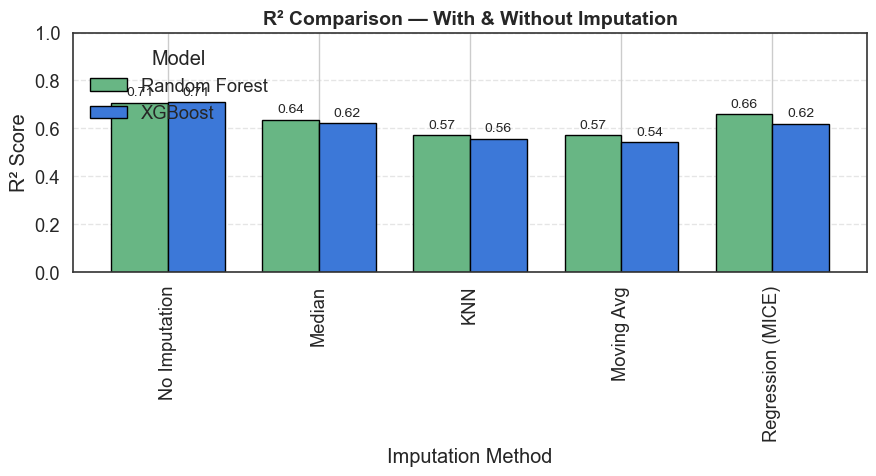

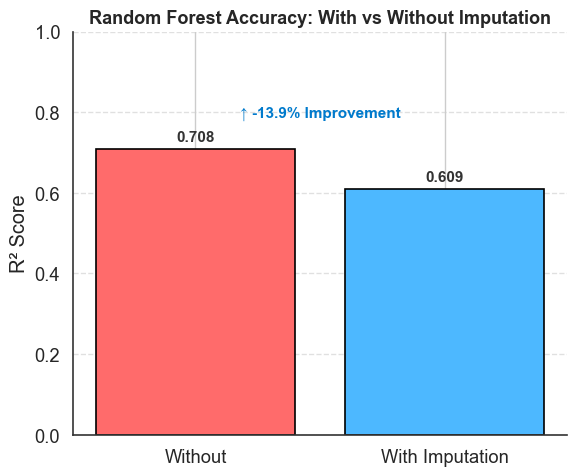

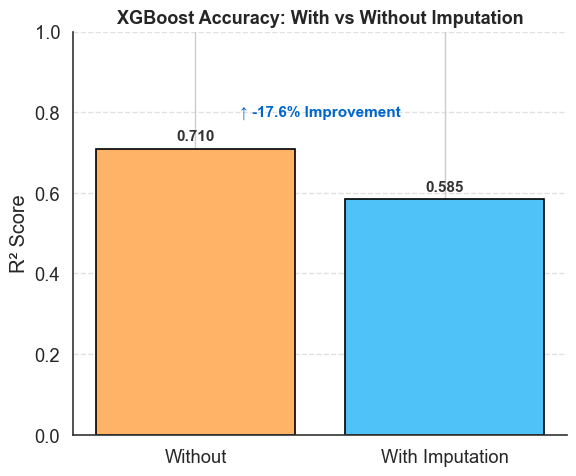

                   Random Forest   XGBoost
No Imputation           0.707560  0.709787
Median                  0.636207  0.621682
KNN                     0.570204  0.557178
Moving Avg              0.571098  0.542420
Regression (MICE)       0.659690  0.619047


In [30]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  #
from sklearn.impute import IterativeImputer                #
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error


# ------------------------------------------------------------
# Imputation Methods
# ------------------------------------------------------------
def fill_missing_median(df, features):
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = SimpleImputer(strategy='median')
    df_copy[features] = imputer.fit_transform(df_copy[features])
    return df_copy

def fill_missing_knn(df, features, n_neighbors=5):
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_copy[features] = imputer.fit_transform(df_copy[features])
    return df_copy

def fill_missing_moving_average(df, features, window=3):
    df_copy = df.dropna(subset=['O3']).copy()
    for col in features:
        df_copy[col] = df_copy[col].fillna(df_copy[col].rolling(window, min_periods=1).mean())
    return df_copy

def fill_missing_regression(df, features, max_iter=10):
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = IterativeImputer(max_iter=max_iter, random_state=42)
    df_copy[features] = imputer.fit_transform(df_copy[features])
    return df_copy


# ------------------------------------------------------------
# Model Evaluation
# ------------------------------------------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, rmse


# ------------------------------------------------------------
# Main Comparison Function
# ------------------------------------------------------------
def compare_imputation_methods(df, feature_columns, sample_n=30000):
    df = df.sample(n=min(sample_n, len(df)), random_state=42)

    imputation_methods = {
        'No Imputation': lambda x, f: x.dropna(subset=f + ['O3']),
        'Median': fill_missing_median,
        'KNN': fill_missing_knn,
        'Moving Avg': fill_missing_moving_average,
        'Regression (MICE)': fill_missing_regression
    }

    results_r2 = {'Random Forest': {}, 'XGBoost': {}}

    for name, func in imputation_methods.items():
        print(f"\n=== Testing {name} ===")
        df_filled = func(df, feature_columns)
        X = df_filled[feature_columns]
        y = df_filled['O3']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        rf = RandomForestRegressor(n_estimators=120, random_state=42)
        r2_rf, _ = evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test)
        results_r2['Random Forest'][name] = r2_rf

        xgb = HistGradientBoostingRegressor(max_iter=150, random_state=42)
        r2_xgb, _ = evaluate_model(xgb, X_train, X_test, y_train, y_test)
        results_r2['XGBoost'][name] = r2_xgb

        print(f"Random Forest R² = {r2_rf:.3f} | XGBoost R² = {r2_xgb:.3f}")

    # ============================================================
    # Visualization: Advanced Style
    # ============================================================
    sns.set(style="whitegrid", font="Arial", font_scale=1.2)
    plt.rcParams['axes.edgecolor'] = '#333333'
    plt.rcParams['axes.linewidth'] = 1.2

    # --- Plot 1: R² Comparison (All Methods) ---
    r2_df = pd.DataFrame(results_r2)
    fig, ax = plt.subplots(figsize=(9,5))
    bar_colors = ['#999999','#88c999','#66b2ff','#f9cc6c','#d48eff']

    bars = r2_df.plot(kind='bar', ax=ax, color=['#68b684','#3c78d8'], width=0.75, edgecolor='black')
    ax.set_title("R² Comparison — With & Without Imputation", fontsize=14, fontweight='bold')
    ax.set_ylabel("R² Score")
    ax.set_xlabel("Imputation Method")
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # highlight top performer
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=10)
    plt.legend(title="Model", loc='upper left', frameon=False)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: With vs Without Imputation (RF only) ---
    avg_with = np.mean([r2_df.loc[m, 'Random Forest'] for m in r2_df.index if m != 'No Imputation'])
    avg_without = r2_df.loc['No Imputation', 'Random Forest']
    improvement = (avg_with - avg_without) / abs(avg_without) * 100

    fig, ax = plt.subplots(figsize=(6,5))
    bars = ax.bar(['Without', 'With Imputation'], [avg_without, avg_with],
                  color=['#ff6b6b', '#4db8ff'], edgecolor='black', linewidth=1.2)
    ax.set_title("Random Forest Accuracy: With vs Without Imputation", fontsize=13, fontweight='bold')
    ax.set_ylabel("R² Score")
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
 
    for i, bar in enumerate(bars):
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}",
                ha='center', fontsize=11, fontweight='bold', color='#333333')

    ax.text(0.5, max(avg_with, avg_without) + 0.08,
            f"↑ {improvement:.1f}% Improvement", ha='center', fontsize=11,
            fontweight='bold', color='#007acc')

    sns.despine()
    plt.tight_layout()
    plt.show()
    
 # --- Plot 3: With vs Without Imputation (XGBoost only) ---
    avg_with_xgb = np.mean([r2_df.loc[m, 'XGBoost'] for m in r2_df.index if m != 'No Imputation'])
    avg_without_xgb = r2_df.loc['No Imputation', 'XGBoost']
    improvement_xgb = (avg_with_xgb - avg_without_xgb) / abs(avg_without_xgb) * 100

    fig, ax = plt.subplots(figsize=(6,5))
    bars = ax.bar(['Without', 'With Imputation'], [avg_without_xgb, avg_with_xgb],
                  color=['#ffb366', '#4fc3f7'], edgecolor='black', linewidth=1.2)
    ax.set_title("XGBoost Accuracy: With vs Without Imputation", fontsize=13, fontweight='bold')
    ax.set_ylabel("R² Score")
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for i, bar in enumerate(bars):
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}",
                ha='center', fontsize=11, fontweight='bold', color='#333333')

    ax.text(0.5, max(avg_with_xgb, avg_without_xgb) + 0.08,
            f"↑ {improvement_xgb:.1f}% Improvement", ha='center', fontsize=11,
            fontweight='bold', color='#0066cc')

    sns.despine()
    plt.tight_layout()
    plt.show()


    return r2_df


# ============================================================
# Example Usage
# ============================================================
# df = pd.read_csv("India_complete.csv", low_memory=False) 
# feature_columns = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','hour','month','dayofweek']
results = compare_imputation_methods(df, feature_columns, sample_n=1000000)
print(results)
 

Plotting imputation comparison for Station DL005, Feature O3


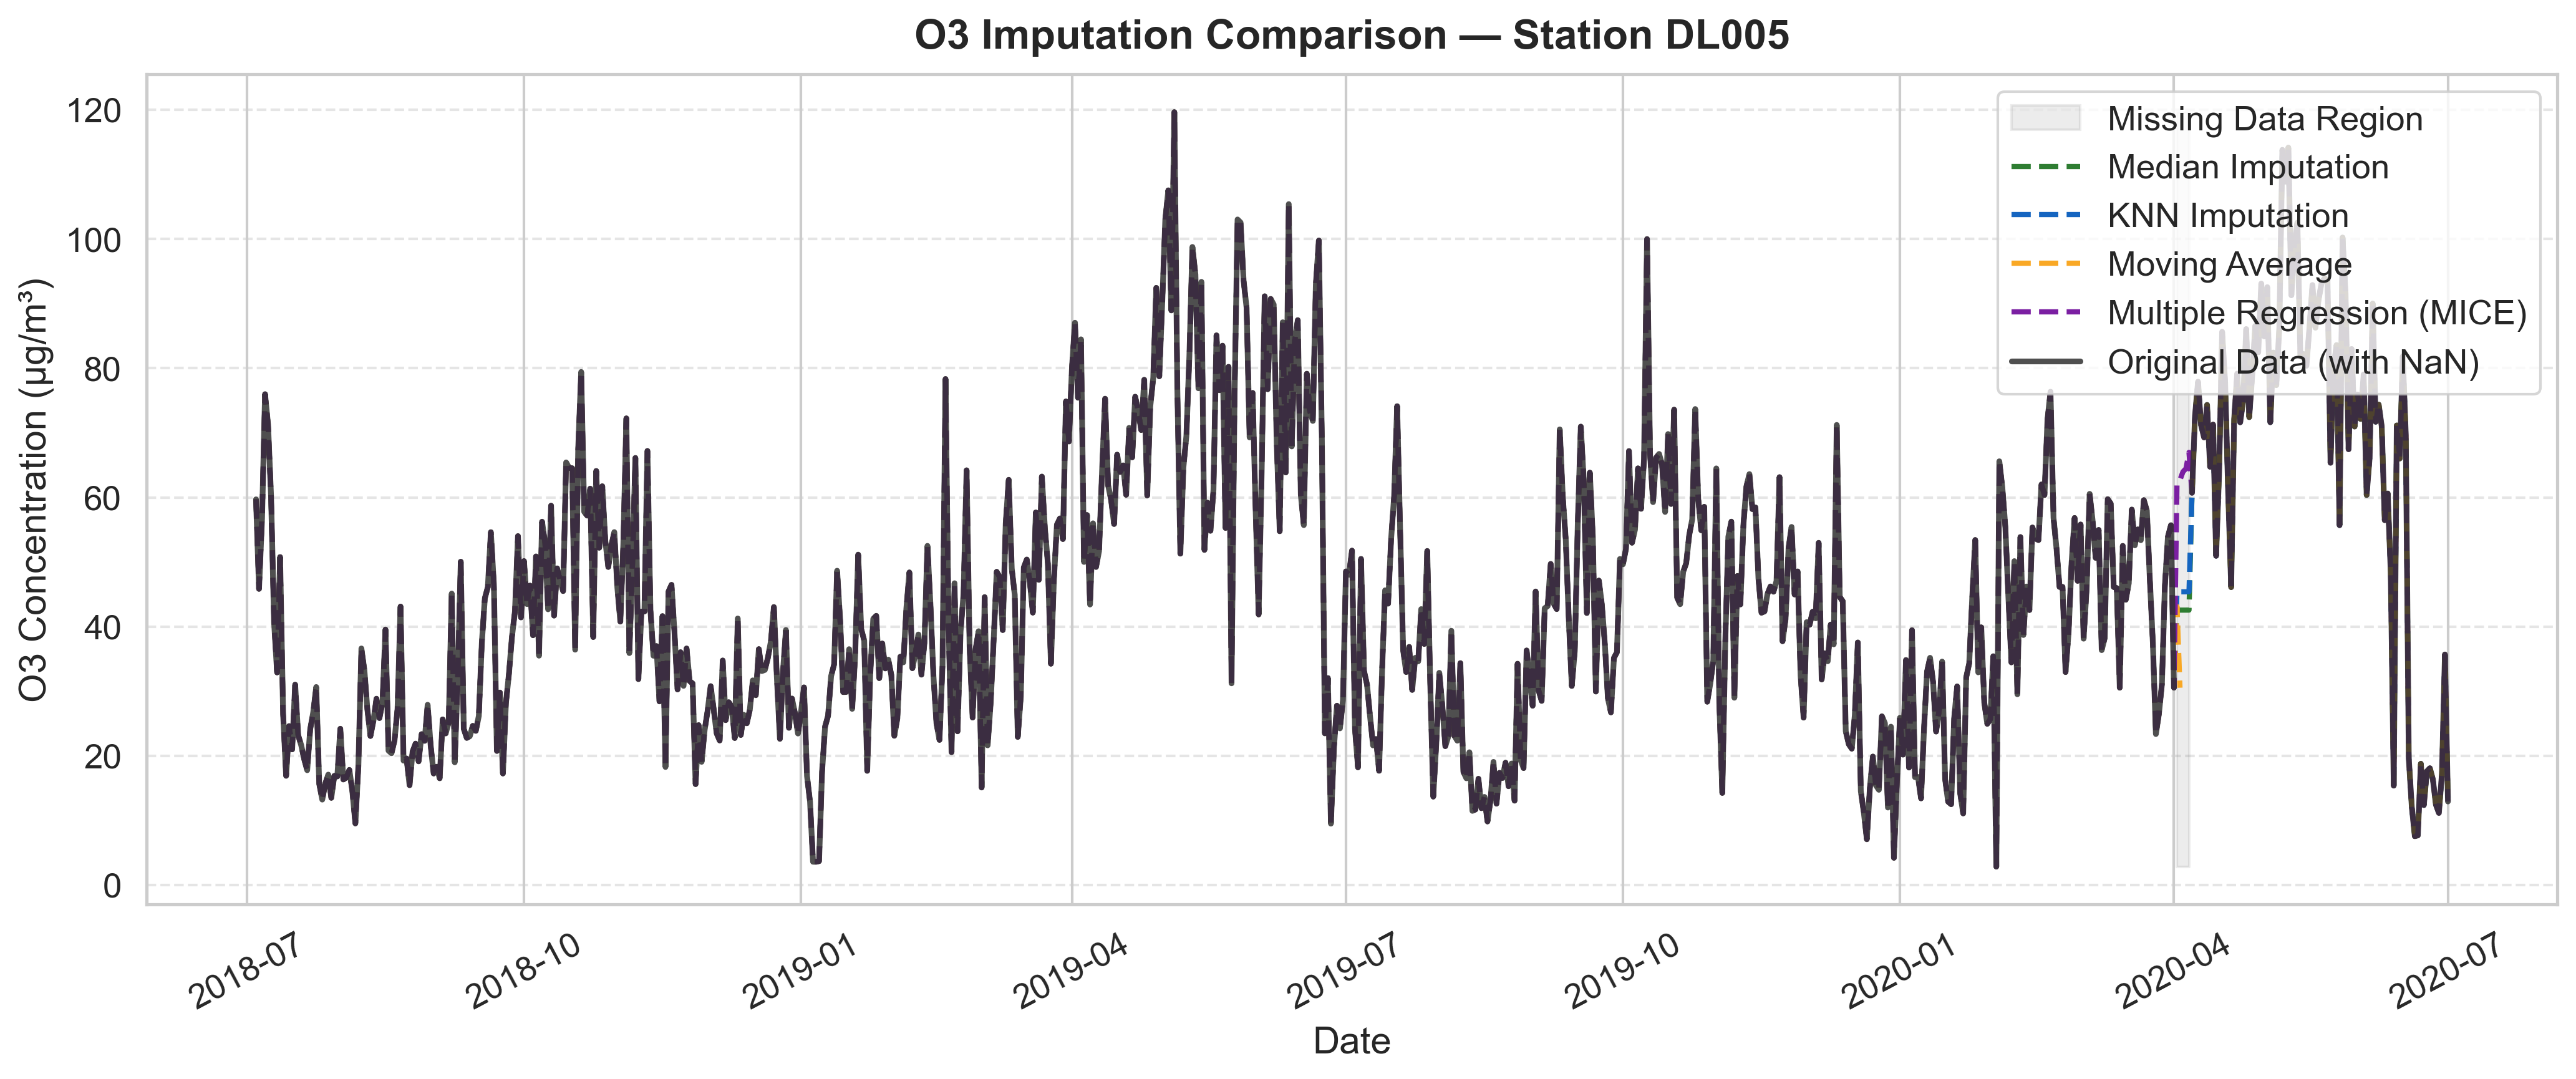

In [45]:
# ========= Imports =========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imputation
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # must be imported before IterativeImputer
from sklearn.impute import IterativeImputer

# ========= Helper Functions =========
def _require_columns(df, cols, name="DataFrame"):
    """Ensure that the DataFrame contains all required columns."""
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{name} is missing required columns: {missing}. "
                       f"Available columns (first 20): {list(df.columns)[:20]} ...")

def _ensure_numeric_series(s, name):
    """Convert a series to numeric if needed, coercing non-numeric values to NaN."""
    if not np.issubdtype(s.dtype, np.number):
        s2 = pd.to_numeric(s, errors='coerce')
        if s2.isna().all():
            raise ValueError(f"Column '{name}' is not numeric and cannot be coerced (all NaN).")
        return s2
    return s

def _ensure_datetime(df, col="datetime"):
    """Ensure that a DataFrame column is in datetime format."""
    if not np.issubdtype(df[col].dtype, np.datetime64):
        df[col] = pd.to_datetime(df[col], errors='coerce')
    if df[col].isna().all():
        raise ValueError(f"Column '{col}' could not be converted to datetime (all NaT).")
    return df

# ========= Imputation Methods (time-series safe, no row dropping) =========
def fill_missing_median_ts(df, feature):
    """Perform median imputation for a single feature (keeps all timestamps)."""
    out = df.copy()
    out[feature] = _ensure_numeric_series(out[feature], feature)
    imp = SimpleImputer(strategy='median')
    out[feature] = imp.fit_transform(out[[feature]])
    return out

def fill_missing_knn_ts(df, feature, n_neighbors=5):
    """Perform KNN imputation for a single feature (keeps all timestamps)."""
    out = df.copy()
    out[feature] = _ensure_numeric_series(out[feature], feature)
    imp = KNNImputer(n_neighbors=n_neighbors)
    out[feature] = imp.fit_transform(out[[feature]])
    return out

def fill_missing_moving_average_ts(df, feature, window=3):
    """Perform moving average imputation (rolling mean) for a single feature."""
    out = df.copy()
    out[feature] = _ensure_numeric_series(out[feature], feature)
    roll = out[feature].rolling(window=window, min_periods=1).mean()
    out[feature] = out[feature].where(~out[feature].isna(), roll)
    return out

def fill_missing_regression_ts(df, feature, extra_features=None, max_iter=10):
    """
    Perform Multiple Imputation by Chained Equations (MICE).
    Safely imputes only the target feature, without dropping rows.
    Automatically selects numeric columns and skips all-NaN predictors.
    """
    out = df.copy()

    # Columns to protect (not used as predictors)
    protected = {'datetime', 'Date', 'StationId', 'StationName', 'City', 'State', 'Status'}

    # Select numeric predictor columns
    if extra_features is not None:
        num_cols = [c for c in extra_features if c in out.columns]
    else:
        num_cols = [c for c in out.columns
                    if (c not in protected)
                    and np.issubdtype(out[c].dtype, np.number)]

    # Ensure the target column is included
    if feature not in num_cols:
        num_cols.append(feature)

    # Convert to numeric and drop columns that are all NaN
    X = out[num_cols].apply(lambda s: pd.to_numeric(s, errors='coerce'))
    X = X.dropna(axis=1, how='all')

    # If the target column is lost, raise an error
    if feature not in X.columns:
        raise ValueError(f"MICE failed: target column '{feature}' became all NaN.")

    # If too few valid predictors exist, fallback to median imputation
    if X.shape[1] < 2:
        print(f"⚠️ Warning: only '{feature}' has valid numeric data. Falling back to median imputation.")
        imp = SimpleImputer(strategy='median')
        out[feature] = imp.fit_transform(out[[feature]])
        return out

    # Perform MICE imputation
    imp = IterativeImputer(max_iter=max_iter, random_state=42)
    X_filled = imp.fit_transform(X)
    X_filled = pd.DataFrame(X_filled, columns=X.columns, index=X.index)

    # Replace only the target column
    out[feature] = X_filled[feature]
    return out

# ========= Main Plotting Function =========
def plot_imputation_timeseries(df, feature='O3', station_id=None, save_fig=True):
    """
    Visualize and compare different imputation methods for a single monitoring station over time.
    Requirements: df must contain ['StationId', 'datetime', feature].
    """

    # Basic checks
    _require_columns(df, ['StationId', 'datetime', feature], name="df")
    df = df.copy()
    df = _ensure_datetime(df, 'datetime')

    # Choose the station (default: station with most missing data)
    if station_id is None:
        try:
            missing_counts = df.groupby('StationId')[feature].apply(
                lambda x: pd.to_numeric(x, errors='coerce').isna().sum()
            )
            station_id = missing_counts.idxmax()
        except Exception:
            station_id = df['StationId'].mode().iloc[0]

    print(f"Plotting imputation comparison for Station {station_id}, Feature {feature}")

    # Filter and sort data
    df_station = df[df['StationId'] == station_id].copy()
    if df_station.empty:
        raise ValueError(f"Station '{station_id}' not found in the data.")
    df_station.sort_values('datetime', inplace=True)

    # Original series (with NaNs kept)
    df_station[feature] = pd.to_numeric(df_station[feature], errors='coerce')
    original = df_station[['datetime', feature]].rename(columns={feature: 'Original'})

    # Apply four imputation methods
    extra_feats = [c for c in df_station.columns
                   if c not in {'datetime', 'Date', 'StationId', 'StationName', 'City', 'State', 'Status'}
                   and c != feature
                   and np.issubdtype(df_station[c].dtype, np.number)]

    df_med = fill_missing_median_ts(df_station, feature)
    df_knn = fill_missing_knn_ts(df_station, feature)
    df_mov = fill_missing_moving_average_ts(df_station, feature)
    df_reg = fill_missing_regression_ts(df_station, feature, extra_features=extra_feats or None)

    # Align all results on the same timeline
    merged = original.copy()
    for name, data in [('Median', df_med), ('KNN', df_knn),
                       ('MovingAvg', df_mov), ('Regression', df_reg)]:
        tmp = data[['datetime', feature]].rename(columns={feature: name})
        merged = pd.merge(merged, tmp, on='datetime', how='left')

    # ===== Visualization =====
    sns.set(style="whitegrid", font="Arial", font_scale=1.2)
    plt.figure(figsize=(14, 6), dpi=300)

    # Gray shaded area: missing regions
    nan_mask = merged['Original'].isna()
    if nan_mask.any():
        ymin = np.nanmin(merged[['Original', 'Median', 'KNN', 'MovingAvg', 'Regression']].values)
        ymax = np.nanmax(merged[['Original', 'Median', 'KNN', 'MovingAvg', 'Regression']].values)
        plt.fill_between(merged['datetime'], ymin, ymax,
                         where=nan_mask, color='gray', alpha=0.15,
                         label='Missing Data Region', zorder=1)

    # Imputed series (overlay)
    plt.plot(merged['datetime'], merged['Median'], '--', color='#2e7d32', linewidth=2,
             label='Median Imputation', zorder=3)
    plt.plot(merged['datetime'], merged['KNN'], '--', color='#1565c0', linewidth=2,
             label='KNN Imputation', zorder=3)
    plt.plot(merged['datetime'], merged['MovingAvg'], '--', color='#f9a825', linewidth=2,
             label='Moving Average', zorder=3)
    plt.plot(merged['datetime'], merged['Regression'], '--', color='#7b1fa2', linewidth=2,
             label='Multiple Regression (MICE)', zorder=3)

    # Original curve (broken at NaNs)
    plt.plot(merged['datetime'], merged['Original'], color='#303030',
             linewidth=2.2, alpha=0.85, label='Original Data (with NaN)', zorder=4)

    plt.title(f"{feature} Imputation Comparison — Station {station_id}",
              fontsize=16, fontweight='bold', pad=10)
    plt.xlabel("Date")
    plt.ylabel(f"{feature} Concentration (µg/m³)")
    plt.xticks(rotation=28)
    plt.legend(loc='upper right', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_fig:
        fn = f"imputation_comparison_{station_id}_{feature}.png"
        plt.savefig(fn, dpi=300, bbox_inches='tight')
        print(f"✅ Saved high-resolution figure: {fn}")

    plt.show()
    return merged


# ===================== Example Usage =====================
# Make sure df contains: ['StationId', 'datetime', 'O3'] at minimum
merged = plot_imputation_timeseries(df, feature='O3', station_id='DL005', save_fig=False)


With k cross validation 


=== Testing No Imputation ===
Random Forest R² = 0.395 ± 0.074 | XGBoost R² = 0.515 ± 0.081

=== Testing Median ===
Random Forest R² = 0.339 ± 0.059 | XGBoost R² = 0.440 ± 0.084

=== Testing KNN ===
Random Forest R² = 0.257 ± 0.059 | XGBoost R² = 0.352 ± 0.110

=== Testing Moving Avg ===
Random Forest R² = 0.276 ± 0.054 | XGBoost R² = 0.332 ± 0.077

=== Testing Regression (MICE) ===


D:\LegionZone\conda\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Random Forest R² = 0.368 ± 0.059 | XGBoost R² = 0.434 ± 0.067


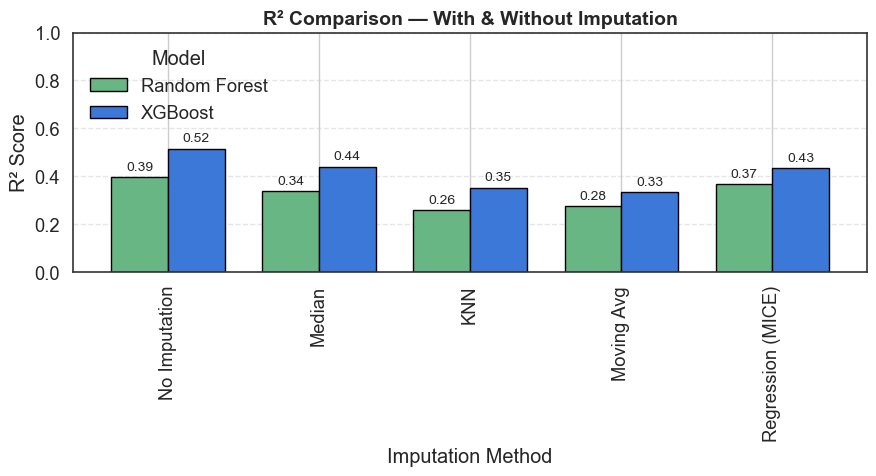

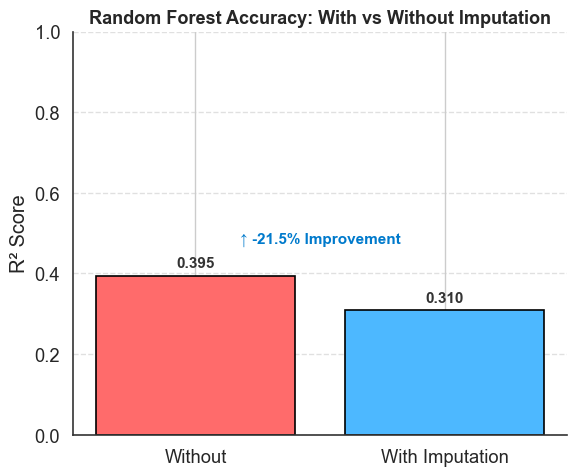

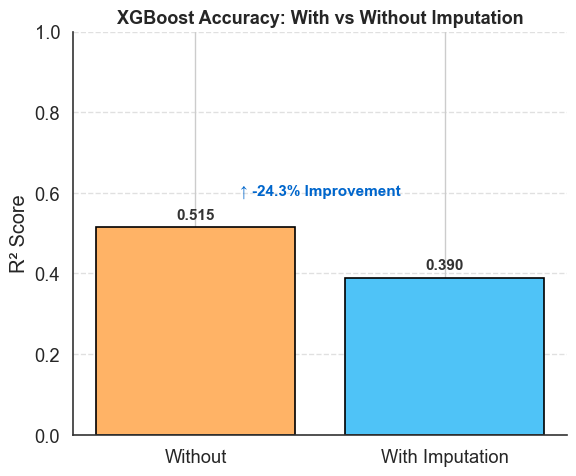

                   Random Forest   XGBoost
No Imputation           0.394655  0.515050
Median                  0.338750  0.440333
KNN                     0.257280  0.352247
Moving Avg              0.275512  0.332307
Regression (MICE)       0.367642  0.434096


In [43]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer                
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error


# ------------------------------------------------------------
# Imputation Methods
# ------------------------------------------------------------
def fill_missing_median(df, features):
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = SimpleImputer(strategy='median')
    df_copy[features] = imputer.fit_transform(df_copy[features])
    return df_copy

def fill_missing_knn(df, features, n_neighbors=5):
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_copy[features] = imputer.fit_transform(df_copy[features])
    return df_copy

def fill_missing_moving_average(df, features, window=3):
    df_copy = df.dropna(subset=['O3']).copy()
    for col in features:
        df_copy[col] = df_copy[col].fillna(df_copy[col].rolling(window, min_periods=1).mean())
    return df_copy

def fill_missing_regression(df, features, max_iter=10):
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = IterativeImputer(max_iter=max_iter, random_state=42)
    df_copy[features] = imputer.fit_transform(df_copy[features])
    return df_copy


# ------------------------------------------------------------
# Model Evaluation
# ------------------------------------------------------------
from sklearn.model_selection import KFold, cross_val_score

def evaluate_model(model, X, y, scaling=True, k=5):
    """
    Evaluate model using k-fold cross-validation (default k=5)
    """
    if scaling:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = np.array(X)

    cv = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return np.mean(scores), np.std(scores)



# ------------------------------------------------------------
# Main Comparison Function
# ------------------------------------------------------------
def compare_imputation_methods(df, feature_columns, sample_n=30000):
    df = df.sample(n=min(sample_n, len(df)), random_state=42)

    imputation_methods = {
        'No Imputation': lambda x, f: x.dropna(subset=f + ['O3']),
        'Median': fill_missing_median,
        'KNN': fill_missing_knn,
        'Moving Avg': fill_missing_moving_average,
        'Regression (MICE)': fill_missing_regression
    }

    results_r2 = {'Random Forest': {}, 'XGBoost': {}}

    for name, func in imputation_methods.items():
        print(f"\n=== Testing {name} ===")
        df_filled = func(df, feature_columns)
        X = df_filled[feature_columns]
        y = df_filled['O3']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        rf = RandomForestRegressor(n_estimators=120, random_state=42)
        r2_rf, std_rf = evaluate_model(rf, X, y, scaling=True, k=5)
        results_r2['Random Forest'][name] = r2_rf
        
        xgb = HistGradientBoostingRegressor(max_iter=150, random_state=42)
        r2_xgb, std_xgb = evaluate_model(xgb, X, y, scaling=False, k=5)
        results_r2['XGBoost'][name] = r2_xgb
        
        print(f"Random Forest R² = {r2_rf:.3f} ± {std_rf:.3f} | XGBoost R² = {r2_xgb:.3f} ± {std_xgb:.3f}")


    # ============================================================
    # Visualization: Advanced Style
    # ============================================================
    sns.set(style="whitegrid", font="Arial", font_scale=1.2)
    plt.rcParams['axes.edgecolor'] = '#333333'
    plt.rcParams['axes.linewidth'] = 1.2

    # --- Plot 1: R² Comparison (All Methods) ---
    r2_df = pd.DataFrame(results_r2)
    fig, ax = plt.subplots(figsize=(9,5))
    bar_colors = ['#999999','#88c999','#66b2ff','#f9cc6c','#d48eff']

    bars = r2_df.plot(kind='bar', ax=ax, color=['#68b684','#3c78d8'], width=0.75, edgecolor='black')
    ax.set_title("R² Comparison — With & Without Imputation", fontsize=14, fontweight='bold')
    ax.set_ylabel("R² Score")
    ax.set_xlabel("Imputation Method")
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # highlight top performer
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=10)
    plt.legend(title="Model", loc='upper left', frameon=False)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: With vs Without Imputation (RF only) ---
    avg_with = np.mean([r2_df.loc[m, 'Random Forest'] for m in r2_df.index if m != 'No Imputation'])
    avg_without = r2_df.loc['No Imputation', 'Random Forest']
    improvement = (avg_with - avg_without) / abs(avg_without) * 100

    fig, ax = plt.subplots(figsize=(6,5))
    bars = ax.bar(['Without', 'With Imputation'], [avg_without, avg_with],
                  color=['#ff6b6b', '#4db8ff'], edgecolor='black', linewidth=1.2)
    ax.set_title("Random Forest Accuracy: With vs Without Imputation", fontsize=13, fontweight='bold')
    ax.set_ylabel("R² Score")
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
 
    for i, bar in enumerate(bars):
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}",
                ha='center', fontsize=11, fontweight='bold', color='#333333')

    ax.text(0.5, max(avg_with, avg_without) + 0.08,
            f"↑ {improvement:.1f}% Improvement", ha='center', fontsize=11,
            fontweight='bold', color='#007acc')

    sns.despine()
    plt.tight_layout()
    plt.show()
    
 # --- Plot 3: With vs Without Imputation (XGBoost only) ---
    avg_with_xgb = np.mean([r2_df.loc[m, 'XGBoost'] for m in r2_df.index if m != 'No Imputation'])
    avg_without_xgb = r2_df.loc['No Imputation', 'XGBoost']
    improvement_xgb = (avg_with_xgb - avg_without_xgb) / abs(avg_without_xgb) * 100

    fig, ax = plt.subplots(figsize=(6,5))
    bars = ax.bar(['Without', 'With Imputation'], [avg_without_xgb, avg_with_xgb],
                  color=['#ffb366', '#4fc3f7'], edgecolor='black', linewidth=1.2)
    ax.set_title("XGBoost Accuracy: With vs Without Imputation", fontsize=13, fontweight='bold')
    ax.set_ylabel("R² Score")
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for i, bar in enumerate(bars):
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}",
                ha='center', fontsize=11, fontweight='bold', color='#333333')

    ax.text(0.5, max(avg_with_xgb, avg_without_xgb) + 0.08,
            f"↑ {improvement_xgb:.1f}% Improvement", ha='center', fontsize=11,
            fontweight='bold', color='#0066cc')

    sns.despine()
    plt.tight_layout()
    plt.show()


    return r2_df


# ============================================================
# Example Usage
# ============================================================
# df = pd.read_csv("India_complete.csv", low_memory=False) 
# feature_columns = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','hour','month','dayofweek']
results = compare_imputation_methods(df, feature_columns, sample_n=10000)
print(results)
 